#  Load data and libraries

In [1]:
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense,  Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
#Load data
# Define the path to your data directory
data_dir = '/kaggle/input/polysomnography/motion-and-heart-rate-from-a-wrist-worn-wearable-and-labeled-sleep-from-polysomnography-1.0.0'

# List directories
heart_rate_dir = os.path.join(data_dir, 'heart_rate')
labels_dir = os.path.join(data_dir, 'labels')
motion_dir = os.path.join(data_dir, 'motion')


# Function to load all files but exclude specific subject's files, without the source_file column
def load_files_excluding_subject(directory, column_names, sep=',', header=None, exclude_subject_id=None):
    all_files = []
    for file_name in os.listdir(directory):
        # Skip files containing the subject ID to exclude
        if exclude_subject_id and exclude_subject_id in file_name:
            print(f"Excluding file: {file_name}")  # Optional: print the excluded file name
            continue  # Skip this file

        # Extract subject ID from the file name (assuming ID is part of the file name)
        subject_id = file_name.split('_')[0]  # Adjust the split logic based on your file naming convention
        
        # Load the file as usual without specifying na_values
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path, header=header, names=column_names, sep=sep)
        
        # Add the subject_id column
        df['subject_id'] = subject_id
        
        all_files.append(df)
    
    # Combine all the DataFrames into one
    return pd.concat(all_files, ignore_index=True)


# Load heart rate data, excluding the subject '1455390'
heart_rate_data = load_files_excluding_subject(
    heart_rate_dir, 
    column_names=["time", "heart_rate"], 
    sep=',',  # Comma-delimited files
    header=None
)

# Load labels data, excluding the subject '1455390'
labels_data = load_files_excluding_subject(
    labels_dir, 
    column_names=["time", "sleep_stage"], 
    sep='\s+',  # Space-delimited files
    header=None
    
)

# Load motion data, excluding the subject '1455390'
motion_data = load_files_excluding_subject(
    motion_dir, 
    column_names=["time", "x_accel", "y_accel", "z_accel"], 
    sep='\s+',  # Space-delimited files
    header=None
)

# Display the combined data (optionally)
print("\nCombined Heart Rate Data:")
print(heart_rate_data.head())

print("\nCombined Labels Data:")
print(labels_data.head())

print("\nCombined Motion Data:")
print(motion_data.head())


Combined Heart Rate Data:
           time  heart_rate subject_id
0 -573802.82896        84.0    1360686
1 -573385.82896        77.0    1360686
2 -573320.82902        75.0    1360686
3 -572814.45419        94.0    1360686
4 -572673.45401       105.0    1360686

Combined Labels Data:
   time  sleep_stage subject_id
0     0           -1    6220552
1    30           -1    6220552
2    60           -1    6220552
3    90           -1    6220552
4   120           -1    6220552

Combined Motion Data:
           time   x_accel   y_accel   z_accel subject_id
0 -24594.420380 -0.110245 -0.245087 -0.947861    5132496
1 -24594.359365 -0.117630 -0.243637 -0.949982    5132496
2 -24594.358521 -0.116684 -0.216202 -0.954498    5132496
3 -24594.357306 -0.113068 -0.208908 -0.973587    5132496
4 -24594.356321 -0.112137 -0.216721 -0.965683    5132496


# Preprocessing

In [3]:
# Convert to time series
heart_rate_data_ts = heart_rate_data.copy()
motion_data_ts = motion_data.copy()
labels_data_ts = labels_data.copy()
heart_rate_data_ts['time'] = pd.to_datetime(heart_rate_data_ts['time'], unit='s', errors='coerce')
motion_data_ts['time'] = pd.to_datetime(motion_data_ts['time'], unit='s', errors='coerce')
labels_data_ts['time'] = pd.to_datetime(labels_data_ts['time'], unit='s', errors='coerce')

In [4]:
# Calculate min and max timestamps for each dataset
datasets = {
    'Heart Rate': heart_rate_data_ts,
    'Labels': labels_data_ts,
    'Motion': motion_data_ts
}

for name, df in datasets.items():
    start_time = df['time'].min()
    end_time = df['time'].max()
    subjects = df['subject_id'].unique()
    print(f"{name} Data:")
    print(f"  Start Time: {start_time}")
    print(f"  End Time: {end_time}")
    print(f"  Unique Subjects: {subjects}\n")

# Check for overlapping time ranges
# Assuming all datasets should use the same subject_id
common_subjects = set(heart_rate_data['subject_id']) & set(labels_data['subject_id']) & set(motion_data['subject_id'])
print(f"{len(common_subjects)} common Subjects Across Datasets: {common_subjects}")

Heart Rate Data:
  Start Time: 1969-12-25 00:00:08.708570
  End Time: 1970-01-01 10:25:41.709980
  Unique Subjects: ['1360686' '6220552' '9961348' '3509524' '1455390' '781756' '8686948'
 '9618981' '5132496' '8000685' '7749105' '46343' '8173033' '8692923'
 '2598705' '5383425' '4018081' '844359' '8258170' '4314139' '1449548'
 '5498603' '9106476' '1066528' '8530312' '5797046' '1818471' '4426783'
 '3997827' '2638030' '759667']

Labels Data:
  Start Time: 1970-01-01 00:00:00
  End Time: 1970-01-01 08:14:30
  Unique Subjects: ['6220552' '9618981' '5797046' '5132496' '4426783' '4314139' '9961348'
 '1066528' '3509524' '4018081' '8173033' '8000685' '844359' '2598705'
 '8530312' '9106476' '46343' '8692923' '5383425' '7749105' '1449548'
 '759667' '8258170' '1818471' '781756' '5498603' '3997827' '1360686'
 '1455390' '2638030' '8686948']

Motion Data:
  Start Time: 1969-12-25 19:50:09.295909
  End Time: 1970-01-03 20:54:14.922096
  Unique Subjects: ['5132496' '8686948' '8258170' '8173033' '844359' 

In [5]:
# Function to calculate time steps for selected subjects
def calculate_time_steps_for_selected(data, dataset_name, selected_subjects):
    time_steps = {}
    print(f"\nAnalyzing {dataset_name} for selected subjects: {selected_subjects}\n")
    for subject_id in selected_subjects:
        if subject_id in data['subject_id'].unique():
            subject_data = data[data['subject_id'] == subject_id]
            diffs = subject_data['time'].sort_values().diff().dropna()
            unique_steps = diffs.unique()
            time_steps[subject_id] = unique_steps
            print(f"{dataset_name} - Subject {subject_id}: Unique Time Steps: {unique_steps}")
        else:
            print(f"{dataset_name} - Subject {subject_id}: Not found in data.")
    return time_steps

# List of selected subjects to analyze
selected_subjects = ['1360686', '6220552']  # Replace with the IDs you want to analyze

# Calculate time steps for selected subjects in each dataset
heart_rate_steps_selected = calculate_time_steps_for_selected(heart_rate_data, "Heart Rate", selected_subjects)
labels_steps_selected = calculate_time_steps_for_selected(labels_data, "Labels", selected_subjects)
motion_steps_selected = calculate_time_steps_for_selected(motion_data, "Motion", selected_subjects)


Analyzing Heart Rate for selected subjects: ['1360686', '6220552']

Heart Rate - Subject 1360686: Unique Time Steps: [417.         64.99994   506.37483   ...   1.9999699   9.9999699
  10.9999699]
Heart Rate - Subject 6220552: Unique Time Steps: [485.37444   575.87394   201.50099   ...   5.01173     7.0000301
   9.9999699]

Analyzing Labels for selected subjects: ['1360686', '6220552']

Labels - Subject 1360686: Unique Time Steps: [30.]
Labels - Subject 6220552: Unique Time Steps: [30.]

Analyzing Motion for selected subjects: ['1360686', '6220552']

Motion - Subject 1360686: Unique Time Steps: [0.018682  0.0198307 0.0211273 ... 0.0189547 0.0243969 0.0149031]
Motion - Subject 6220552: Unique Time Steps: [0.1105852 0.0009189 0.000827  ... 0.0138189 0.011365  0.0099054]


This indicates that there are different time steps for each dataset, being labels the only one with a constant time step and the one needed.

Then the other two datasets heart rate and motion need to be resample with the same time step as labels data set (30s).

ALso was noticed that the start time of labels is after the others two then all datasets shoulds start at 1970-01-01 00:00:00

In [6]:
# Define the cutoff datetime
cutoff_time = pd.Timestamp("1970-01-01 00:00:00")

# Filter out rows with 'time' before the cutoff in each DataFrame
heart_rate_data_ts = heart_rate_data_ts[heart_rate_data_ts['time'] >= cutoff_time]
motion_data_ts = motion_data_ts[motion_data_ts['time'] >= cutoff_time]
labels_data_ts = labels_data_ts[labels_data_ts['time'] >= cutoff_time]
print(heart_rate_data_ts)
print(motion_data_ts)
print(labels_data_ts)

                                time  heart_rate subject_id
1335   1970-01-01 00:00:01.757280111        77.0    1360686
1336   1970-01-01 00:00:04.757280111        77.0    1360686
1337   1970-01-01 00:00:07.757309914        77.0    1360686
1338   1970-01-01 00:00:17.757280111        70.0    1360686
1339   1970-01-01 00:00:20.757280111        69.0    1360686
...                              ...         ...        ...
254420 1970-01-01 03:57:02.841870100        60.0     759667
254421 1970-01-01 03:57:11.841870100        57.0     759667
254422 1970-01-01 03:57:14.841870100        56.0     759667
254423 1970-01-01 03:57:19.841870100        57.0     759667
254424 1970-01-01 03:57:24.841840000        57.0     759667

[187268 rows x 3 columns]
                                  time   x_accel   y_accel   z_accel  \
124315   1970-01-01 00:00:00.012832165 -0.199692  0.302658 -0.945312   
124316   1970-01-01 00:00:00.026938915 -0.419891  0.137589 -0.869583   
124317   1970-01-01 00:00:00.04241299

In [7]:
# Now we can process each subject separately
subject_ids = heart_rate_data['subject_id'].unique()  # Get the unique subject IDs

# Initialize a dictionary to store merged data for each subject
subject_data = {}

for subject_id in subject_ids:
    # Filter data for the current subject
    subject_heart_rate_data = heart_rate_data_ts[heart_rate_data_ts['subject_id'] == subject_id].drop('subject_id', axis=1)
    subject_motion_data = motion_data_ts[motion_data_ts['subject_id'] == subject_id].drop('subject_id', axis=1)
    subject_labels_data = labels_data_ts[labels_data_ts['subject_id'] == subject_id].drop('subject_id', axis=1)
    
    subject_heart_rate_data.set_index('time', inplace=True)
    subject_motion_data.set_index('time', inplace=True)
    subject_labels_data.set_index('time', inplace=True)

    # Round time to the nearest 30 seconds before resampling
    subject_motion_data['time'] = subject_motion_data.index.round('30s')
    subject_heart_rate_data['time'] = subject_heart_rate_data.index.round('30s')
    subject_motion_data= subject_motion_data.drop('time', axis=1)
    subject_heart_rate_data= subject_heart_rate_data.drop('time', axis=1)
    # Resample heart rate and motion data with a 30s interval
    heart_rate_resampled = subject_heart_rate_data.resample('30s').median()
    motion_resampled = subject_motion_data.resample('30s').median()
    

    # Merge labels with heart rate and motion data on time index
    merged_data = pd.merge(subject_labels_data, heart_rate_resampled, left_index=True, right_index=True, how='left')
    merged_data = pd.merge(merged_data, motion_resampled, left_index=True, right_index=True, how='left')

    # Store the merged data for the current subject
    subject_data[subject_id] = merged_data

In [8]:
# List to store all the dataframes
combined_data_list = []

# Iterate through the dictionary and add the subject_id to each dataframe
for subject_id, df in subject_data.items():
    df['subject_id'] = subject_id  # Add the subject_id as a new column
    # Keep the time index as part of the DataFrame, avoid resetting the index
    df = df.set_index(df.index)  # This ensures that the time index is retained for each subject
    combined_data_list.append(df)  # Append the dataframe to the list

# Concatenate all the dataframes into one, with the index preserved
combined_data = pd.concat(combined_data_list, ignore_index=False)

# Display the first few rows of the combined dataframe
combined_data.head()

,sleep_stage,heart_rate,x_accel,y_accel,z_accel,subject_id
time,,,,,,
1970-01-01 00:00:00,-1,73.5,NaN,NaN,NaN,1360686
1970-01-01 00:00:30,-1,77.0,NaN,NaN,NaN,1360686
1970-01-01 00:01:00,-1,77.0,NaN,NaN,NaN,1360686
1970-01-01 00:01:30,-1,75.5,NaN,NaN,NaN,1360686
1970-01-01 00:02:00,-1,74.5,NaN,NaN,NaN,1360686


# EDA

In [9]:
# Inspect column names and data types
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27211 entries, 1970-01-01 00:00:00 to 1970-01-01 03:57:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sleep_stage  27211 non-null  int64  
 1   heart_rate   26350 non-null  float64
 2   x_accel      25971 non-null  float64
 3   y_accel      25971 non-null  float64
 4   z_accel      25971 non-null  float64
 5   subject_id   27211 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ MB


In [10]:
# Review missing values in the merged dataset
missing_values = combined_data.isna().sum()  # Count missing values per column
missing_percentage = (missing_values / len(combined_data)) * 100  # Calculate percentage of missing values

print("\nMissing Values Count:")
print(missing_values)

print("\nMissing Values Percentage:")
print(missing_percentage)


Missing Values Count:
sleep_stage       0
heart_rate      861
x_accel        1240
y_accel        1240
z_accel        1240
subject_id        0
dtype: int64

Missing Values Percentage:
sleep_stage    0.000000
heart_rate     3.164162
x_accel        4.556981
y_accel        4.556981
z_accel        4.556981
subject_id     0.000000
dtype: float64


In [11]:
# Count the number of missing values for each subject_id
missing_values_by_subject = combined_data.groupby('subject_id').apply(lambda group: group.isnull().sum())

# Display the missing values count for each subject_id
print(missing_values_by_subject)

            sleep_stage  heart_rate  x_accel  y_accel  z_accel  subject_id
subject_id                                                                
1066528               0          77      124      124      124           0
1360686               0           0       41       41       41           0
1449548               0           0       67       67       67           0
1455390               0           1        0        0        0           0
1818471               0           0        0        0        0           0
2598705               0          30       75       75       75           0
2638030               0           0        0        0        0           0
3509524               0           0        0        0        0           0
3997827               0           0        0        0        0           0
4018081               0           0       12       12       12           0
4314139               0           0        0        0        0           0
4426783               0  

/tmp/ipykernel_23/3761896633.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_by_subject = combined_data.groupby('subject_id').apply(lambda group: group.isnull().sum())


**Review one of the subjects with 7 missing values on motion data**

In [12]:
# Filter rows for subject 8000685
subject_data = combined_data[combined_data['subject_id'] == '8000685']

# Find rows with missing values
missing_rows = subject_data[subject_data.isnull().any(axis=1)]


# Display the rows with missing values
missing_rows

,sleep_stage,heart_rate,x_accel,y_accel,z_accel,subject_id
time,,,,,,
1970-01-01 06:23:00,5,70.0,NaN,NaN,NaN,8000685
1970-01-01 06:23:30,5,71.5,NaN,NaN,NaN,8000685
1970-01-01 06:39:30,2,70.0,NaN,NaN,NaN,8000685
1970-01-01 06:40:00,2,69.5,NaN,NaN,NaN,8000685
1970-01-01 06:40:30,2,69.5,NaN,NaN,NaN,8000685
1970-01-01 06:41:00,2,70.0,NaN,NaN,NaN,8000685
1970-01-01 06:41:30,2,66.0,NaN,NaN,NaN,8000685


In [13]:
# Review missing times on original data (motion_data_ts)
# Define the start and end time values 
start_time = '1970-01-01 06:23:00'  
end_time = '1970-01-01 06:41:31' 
subject_motion_data= motion_data_ts[motion_data_ts['subject_id']== '8000685']
# Filter rows where the time is between the two specified times
filtered_motion_ts = subject_motion_data[(subject_motion_data['time'] >= start_time) & (subject_motion_data['time'] <= end_time)]

filtered_motion_ts

,time,x_accel,y_accel,z_accel,subject_id
40297140,1970-01-01 06:24:10.057827900,-0.774551,-0.031555,-0.628204,8000685
40297141,1970-01-01 06:24:10.071341000,-0.775040,-0.029602,-0.629196,8000685
40297142,1970-01-01 06:24:10.091254000,-0.774063,-0.029098,-0.628708,8000685
40297143,1970-01-01 06:24:10.111291900,-0.773071,-0.027634,-0.629684,8000685
40297144,1970-01-01 06:24:10.131561000,-0.774048,-0.028137,-0.630173,8000685
...,...,...,...,...,...
40342135,1970-01-01 06:39:07.851758000,0.224091,-0.357529,-0.906799,8000685
40342136,1970-01-01 06:39:07.871594900,0.225555,-0.358505,-0.906296,8000685
40342137,1970-01-01 06:39:07.891533900,0.224564,-0.356552,-0.906311,8000685
40342138,1970-01-01 06:39:07.911525000,0.223083,-0.355560,-0.905838,8000685


There are no errors on resampling techiniques indeed the timestamps are missing on the data before resampling, then missing values need to be handle.
Two approches were taken:
1.  Subjects with more than 100 total missing values were deteled
2.  Mask some missing values on data with no missing values and test the imputation methods to decide the best approach per each feature.

In [14]:
# Identify subject_ids that have any missing values in their data
subjects_with_missing_values = combined_data[combined_data.isnull().any(axis=1)]['subject_id'].unique()

# Drop the rows where the subject_id is in the list of subjects with missing values
no_na = combined_data[~combined_data['subject_id'].isin(subjects_with_missing_values)]

# Verify no missing values
no_na.isna().sum()

sleep_stage    0
heart_rate     0
x_accel        0
y_accel        0
z_accel        0
subject_id     0
dtype: int64

In [15]:
# Test methods
# Define RMSE calculation
def calculate_rmse(original, imputed):
    return np.sqrt(mean_squared_error(original, imputed))

# Simulate missing values by randomly masking some data points
def mask_data(data, num_points):
    if num_points > len(data):
        raise ValueError("Number of points to mask exceeds the length of the data.")

    masked_data = data.copy()
    mask_indices = data.sample(n=num_points, random_state=42).index  
    masked_data.loc[mask_indices] = np.nan
    return masked_data, mask_indices

# Imputation methods
def apply_methods(data, method):
    # Ensure index is sorted for interpolation methods
    data = data.sort_index()

    if method == 'forward_fill':
        return data.fillna(method='ffill')
    elif method == 'backward_fill':
        return data.fillna(method='bfill')
    elif method == 'rolling_mean':
        return data.fillna(data.rolling(window=5, min_periods=1).mean())
    elif method == 'spline':
        return data.interpolate(method='spline', order=3)
    elif method == 'linear':
        return data.interpolate(method='linear')
    else:
        raise ValueError(f"Unknown method: {method}")


# Test methods
def evaluate_imputation(data, num_points=100):
    results = {}
    original_data = data.copy()
    masked_data, mask_indices = mask_data(data, num_points)

    for method in ['forward_fill', 'backward_fill','linear']:
        try:
            imputed_data = apply_methods(masked_data, method)
            rmse = calculate_rmse(original_data.loc[mask_indices], imputed_data.loc[mask_indices])
            results[method] = rmse
        except Exception as e:
            print(f"Error with method {method}: {e}")
            results[method] = None

    return results

# Example usage
heart_no_na = no_na['heart_rate'] 
x_no_na = no_na['x_accel']
y_no_na = no_na['y_accel']
z_no_na = no_na['z_accel']
heart_results = evaluate_imputation(heart_no_na, num_points=10)
x_results = evaluate_imputation(x_no_na, num_points=10)
y_results = evaluate_imputation(y_no_na, num_points=10)
z_results = evaluate_imputation(z_no_na, num_points=10)
# Display results
print('-----------Hear rate------')
print("RMSE for each imputation method:")
for method, rmse in heart_results.items():
    if rmse is not None:
        print(f"{method}: {rmse:.4f}")
    else:
        print(f"{method}: Error during calculation")

print('-----------x accel------')
print("RMSE for each imputation method:")
for method, rmse in x_results.items():
    if rmse is not None:
        print(f"{method}: {rmse:.4f}")
    else:
        print(f"{method}: Error during calculation")

print('-----------y accel------')
print("RMSE for each imputation method:")
for method, rmse in y_results.items():
    if rmse is not None:
        print(f"{method}: {rmse:.4f}")
    else:
        print(f"{method}: Error during calculation")

print('-----------z accel------')
print("RMSE for each imputation method:")
for method, rmse in z_results.items():
    if rmse is not None:
        print(f"{method}: {rmse:.4f}")
    else:
        print(f"{method}: Error during calculation")



-----------Hear rate------
RMSE for each imputation method:
forward_fill: 12.1792
backward_fill: 16.0215
linear: 13.5885
-----------x accel------
RMSE for each imputation method:
forward_fill: 0.4771
backward_fill: 0.4508
linear: 0.4281
-----------y accel------
RMSE for each imputation method:
forward_fill: 0.6105
backward_fill: 0.7446
linear: 0.6396
-----------z accel------
RMSE for each imputation method:
forward_fill: 0.9163
backward_fill: 0.8229
linear: 0.8206


/tmp/ipykernel_23/264856937.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
/tmp/ipykernel_23/264856937.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='bfill')
/tmp/ipykernel_23/264856937.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='ffill')
/tmp/ipykernel_23/264856937.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method='bfill')
/tmp/ipykernel_23/264856937.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return dat

1.  Subjects with missing values on heart rate colum were drop since RMSE value is high
2.  For x_accel linear imputation is the one with lower RMSE
3.  For y_accel forward imputation is the one with lower RMSE
4.  For z_accel linear imputation is the one with lower RMSE

All subjects with more than 100 missing values were drop

In [16]:
# Identify the number of missing values for each subject
missing_counts = combined_data.groupby('subject_id').apply(lambda group: group.isnull().sum().sum())

#  Filter subjects with more than 21 missing values
subjects_to_clean = missing_counts[missing_counts > 100].index

# Drop rows where subject_id is in the list of subjects with more than 21 missing values
combined_data_cleaned = combined_data[~combined_data['subject_id'].isin(subjects_to_clean)]

combined_data_cleaned.head()

/tmp/ipykernel_23/2962885818.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_counts = combined_data.groupby('subject_id').apply(lambda group: group.isnull().sum().sum())


,sleep_stage,heart_rate,x_accel,y_accel,z_accel,subject_id
time,,,,,,
1970-01-01 00:00:00,-1,86.0,0.926407,0.361984,-0.113785,6220552
1970-01-01 00:00:30,-1,81.0,0.924339,0.367043,-0.095291,6220552
1970-01-01 00:01:00,-1,82.0,0.186356,0.567917,-0.241776,6220552
1970-01-01 00:01:30,-1,85.0,-0.408997,0.385590,-0.659241,6220552
1970-01-01 00:02:00,-1,80.0,-0.131790,0.511231,-0.845047,6220552


In [17]:
# Fill missing values 

# Drop subjects with missing values in the 'heart_rate' column
subjects_with_missing_heart_rate = combined_data_cleaned[
    combined_data_cleaned['heart_rate'].isnull()
]['subject_id'].unique()

data_cleaned = combined_data_cleaned[
    ~combined_data_cleaned['subject_id'].isin(subjects_with_missing_heart_rate)
]
# Apply linear and forward method
data_cleaned['x_accel'] = data_cleaned['x_accel'].interpolate(method='linear')
data_cleaned['y_accel'] = data_cleaned['y_accel'].fillna(method='ffill')
data_cleaned['z_accel'] = data_cleaned['z_accel'].interpolate(method='linear')

/tmp/ipykernel_23/1638863007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['x_accel'] = data_cleaned['x_accel'].interpolate(method='linear')
/tmp/ipykernel_23/1638863007.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_cleaned['y_accel'] = data_cleaned['y_accel'].fillna(method='ffill')
/tmp/ipykernel_23/1638863007.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['y_accel'] =

In [18]:
# Review missing values in the merged dataset
missing_values = data_cleaned.isna().sum()  # Count missing values per column
missing_percentage = (missing_values / len(data_cleaned)) * 100  # Calculate percentage of missing values

print("\nMissing Values Count:")
print(missing_values)

print("\nMissing Values Percentage:")
print(missing_percentage)


Missing Values Count:
sleep_stage    0
heart_rate     0
x_accel        0
y_accel        0
z_accel        0
subject_id     0
dtype: int64

Missing Values Percentage:
sleep_stage    0.0
heart_rate     0.0
x_accel        0.0
y_accel        0.0
z_accel        0.0
subject_id     0.0
dtype: float64


**Now review the labels**

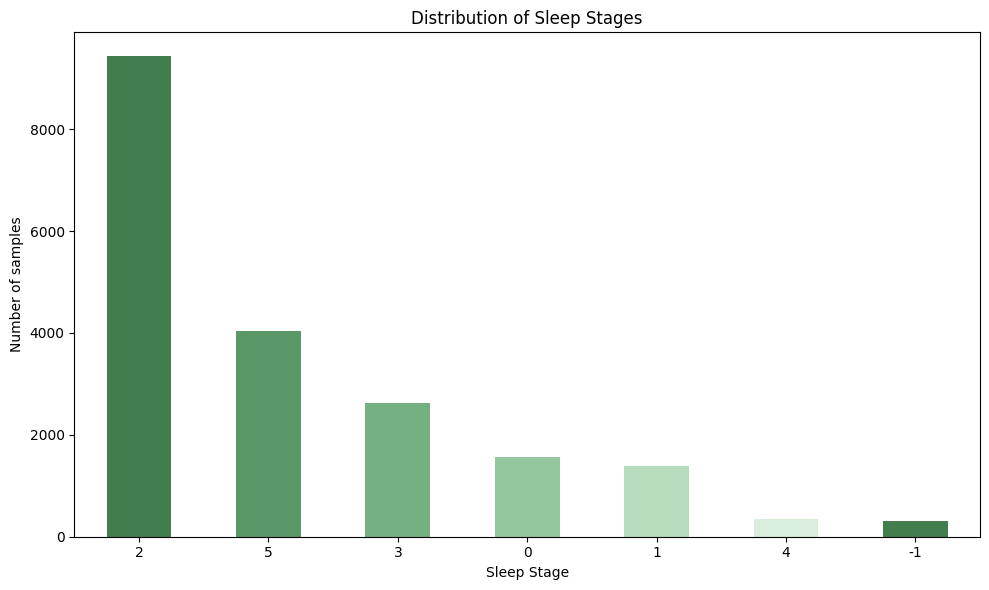

In [19]:
# Count the frequency of each sleep_stage at each time point
label_counts = data_cleaned['sleep_stage'].value_counts()

# Create a color palette that goes from dark to light
palette = sns.cubehelix_palette(start=2, rot=0, dark=0.4, light=0.9, reverse=True)

# Plot the distribution of sleep stages with the color palette
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=palette)
plt.title('Distribution of Sleep Stages')
plt.xlabel('Sleep Stage')
plt.ylabel('Number of samples')
plt.xticks(rotation=0)  # To keep the x labels readable
plt.tight_layout()
plt.show()

In [20]:
# Subjects with lables 4
label_4 =data_cleaned[data_cleaned['sleep_stage'] == 4] 
label_4['subject_id'].value_counts()

subject_id
5383425    190
9618981     83
8258170     83
Name: count, dtype: int64

In [21]:
# Subjects with labels -1
label_m1 =data_cleaned[data_cleaned['sleep_stage'] == -1] 
label_m1['subject_id'].value_counts()

subject_id
844359     52
1818471    30
8173033    30
8692923    29
6220552    27
5797046    23
2638030    21
3997827    19
8686948    16
5498603    15
9106476    14
46343      13
4314139     9
8000685     8
5383425     2
Name: count, dtype: int64

In [22]:
# Sort data and filter subjects with labels -1 and 4
sort_data = data_cleaned.sort_index()  # Sort data by time index if not already sorted

sub_6220552=sort_data[sort_data['subject_id']=='6220552']
sub_9618981=sort_data[sort_data['subject_id']=='9618981']
sub_8258170=sort_data[sort_data['subject_id']=='8258170']
sub_5383425=sort_data[sort_data['subject_id']=='5383425']
sort_data.head()

,sleep_stage,heart_rate,x_accel,y_accel,z_accel,subject_id
time,,,,,,
1970-01-01,-1,86.0,0.926407,0.361984,-0.113785,6220552
1970-01-01,-1,75.0,-0.851837,0.507706,-0.115189,3997827
1970-01-01,0,66.0,-0.856766,0.020920,-0.459526,4426783
1970-01-01,-1,76.5,-0.353516,0.011963,0.934601,1818471
1970-01-01,-1,74.0,-0.444183,-0.640839,-0.469604,5797046


/tmp/ipykernel_23/2655718835.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')  # Get the colormap


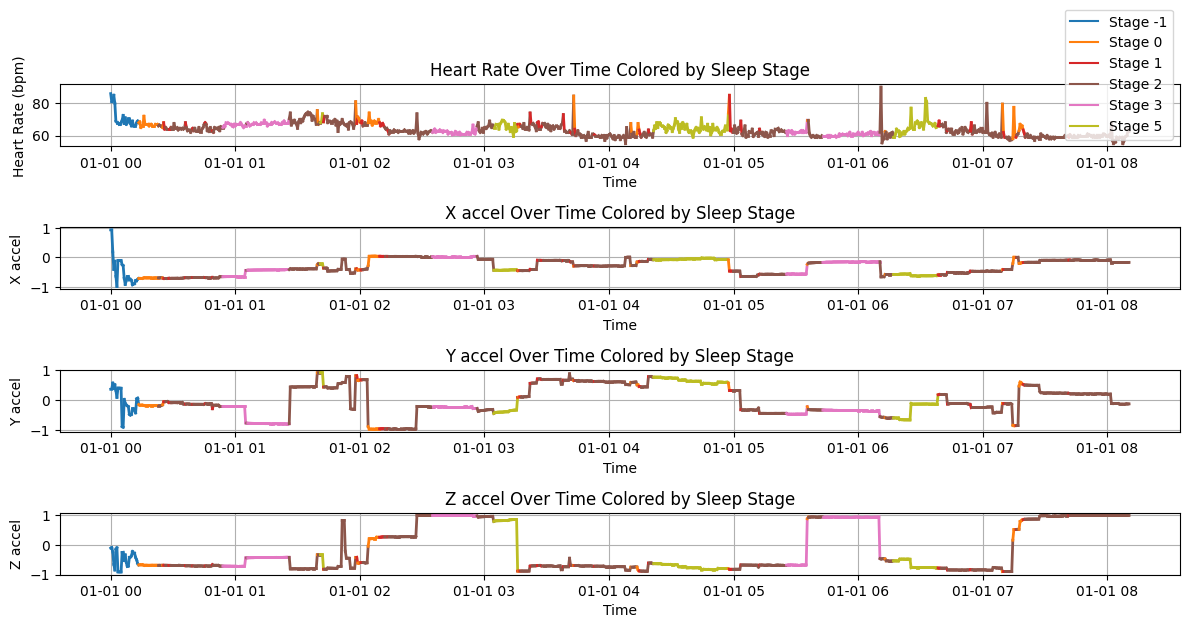

In [23]:
# Plot sub_6220552
# Create a color map for the sleep stages
unique_stages = sub_6220552['sleep_stage'].unique()
cmap = plt.cm.get_cmap('tab10')  # Get the colormap
stage_to_color = {stage: cmap(i / len(unique_stages)) for i, stage in enumerate(sorted(unique_stages))}

# Extract data
heart_rate = sub_6220552['heart_rate'].values
x_axis = sub_6220552['x_accel'].values
y_axis = sub_6220552['y_accel'].values
z_axis = sub_6220552['z_accel'].values
sleep_stage = sub_6220552['sleep_stage'].values
time = sub_6220552.index.values  # Time as a NumPy array for iteration

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [heart_rate[i], heart_rate[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Heart Rate Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [x_axis[i], x_axis[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('X accel Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('X accel')
#plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [y_axis[i], y_axis[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Y accel Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('Y accel')
#plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [z_axis[i], z_axis[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Z accel Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('Z accel')
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_23/2683537947.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')  # Get the colormap


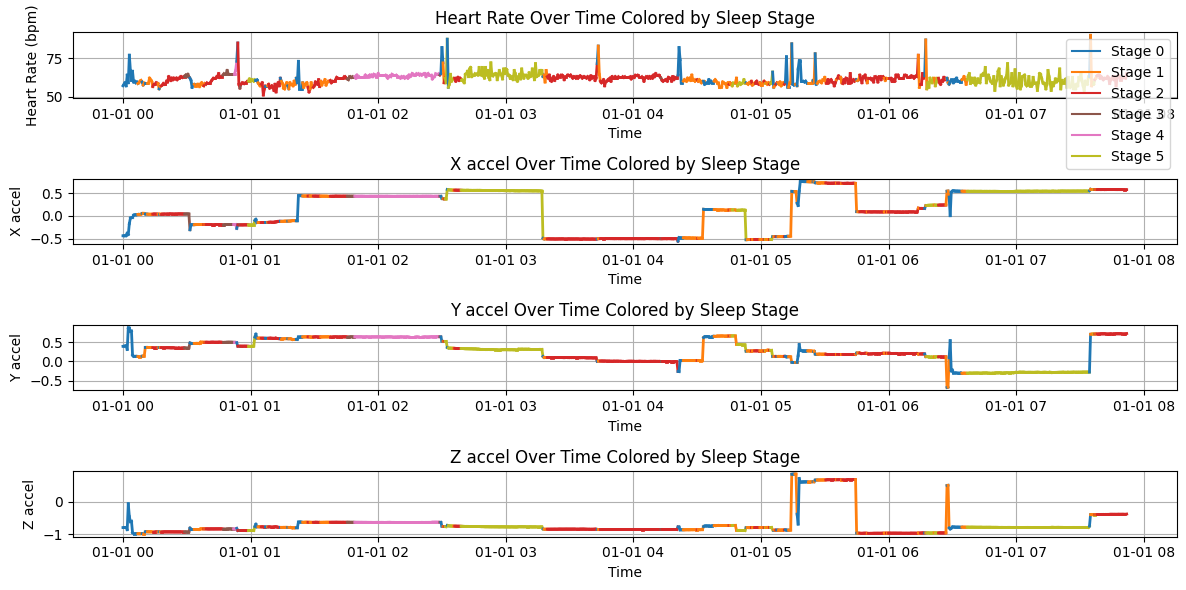

In [24]:
# Plot sub_9618981
# Create a color map for the sleep stages
unique_stages = sub_9618981['sleep_stage'].unique()
cmap = plt.cm.get_cmap('tab10')  # Get the colormap
stage_to_color = {stage: cmap(i / len(unique_stages)) for i, stage in enumerate(sorted(unique_stages))}

# Extract data
heart_rate = sub_9618981['heart_rate'].values
x_axis = sub_9618981['x_accel'].values
y_axis = sub_9618981['y_accel'].values
z_axis = sub_9618981['z_accel'].values
sleep_stage = sub_9618981['sleep_stage'].values
time = sub_9618981.index.values  # Time as a NumPy array for iteration

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [heart_rate[i], heart_rate[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Heart Rate Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [x_axis[i], x_axis[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('X accel Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('X accel')
#plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [y_axis[i], y_axis[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Y accel Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('Y accel')
#plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [z_axis[i], z_axis[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Z accel Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('Z accel')
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_23/3557383499.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')  # Get the colormap


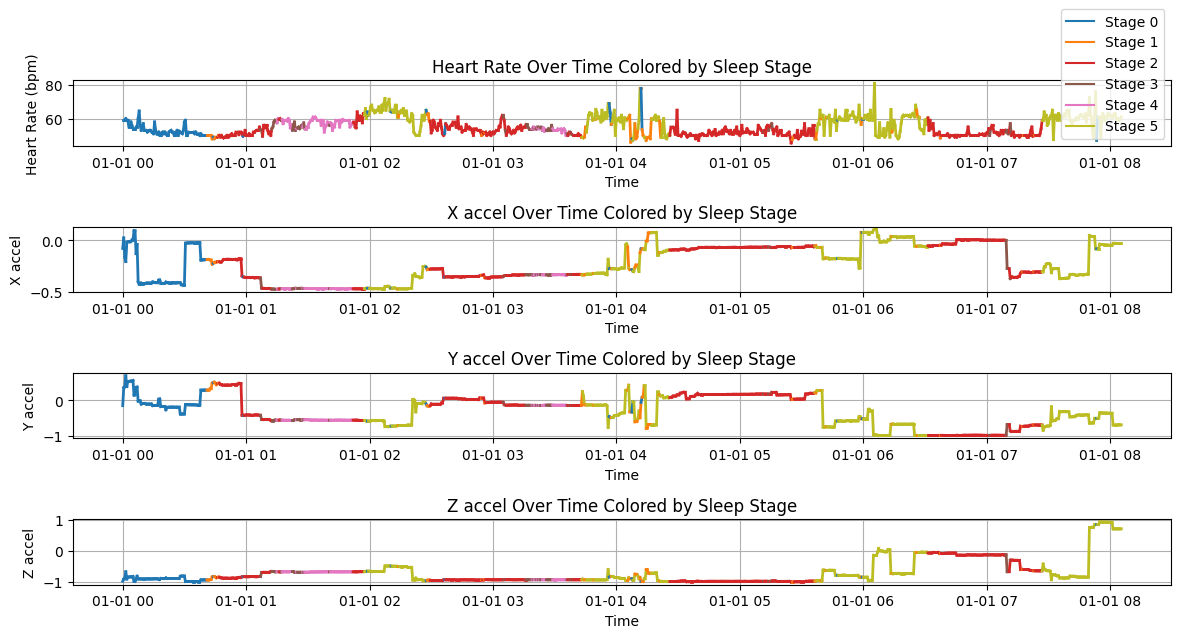

In [25]:
# Plot sub_8258170
# Create a color map for the sleep stages
unique_stages = sub_8258170['sleep_stage'].unique()
cmap = plt.cm.get_cmap('tab10')  # Get the colormap
stage_to_color = {stage: cmap(i / len(unique_stages)) for i, stage in enumerate(sorted(unique_stages))}

# Extract data
heart_rate = sub_8258170['heart_rate'].values
x_axis = sub_8258170['x_accel'].values
y_axis = sub_8258170['y_accel'].values
z_axis = sub_8258170['z_accel'].values
sleep_stage = sub_8258170['sleep_stage'].values
time = sub_8258170.index.values  # Time as a NumPy array for iteration

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [heart_rate[i], heart_rate[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Heart Rate Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [x_axis[i], x_axis[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('X accel Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('X accel')
#plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [y_axis[i], y_axis[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Y accel Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('Y accel')
#plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [z_axis[i], z_axis[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Z accel Over Time Colored by Sleep Stage')
plt.xlabel('Time')
plt.ylabel('Z accel')
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The information labels for the dataset were not clear. The values for classes 1 and 4 were missing. After plotting the data, it was clear that class 4 was near class 3, and class -1 was at the beginning. Then, label -1 was dropped, and class 4 was grouped with class 3. 
And labels 1 and 2 were combine into label 1 and then 3 was converted to 2 and label 5 to 3 to va a continuous label value.

In [26]:
# Rearrange labels
# Drop labels = -1
filtered_data = data_cleaned[data_cleaned['sleep_stage'] != -1]

# Combine labels 1 and 2 into a single label
filtered_data.loc[filtered_data['sleep_stage'] == 2, 'sleep_stage'] = 1
#Convert label 3 to 2
filtered_data.loc[filtered_data['sleep_stage'] == 3, 'sleep_stage'] = 2
#Convert label 5 to 3 and 4 to 3
filtered_data.loc[filtered_data['sleep_stage'] == 5, 'sleep_stage'] = 3
filtered_data.loc[filtered_data['sleep_stage'] == 4, 'sleep_stage'] = 3


filtered_data['sleep_stage'].value_counts()

sleep_stage
1    10824
3     4393
2     2618
0     1564
Name: count, dtype: int64

In [27]:
# Count final number of subjects
len(filtered_data['subject_id'].unique())

23

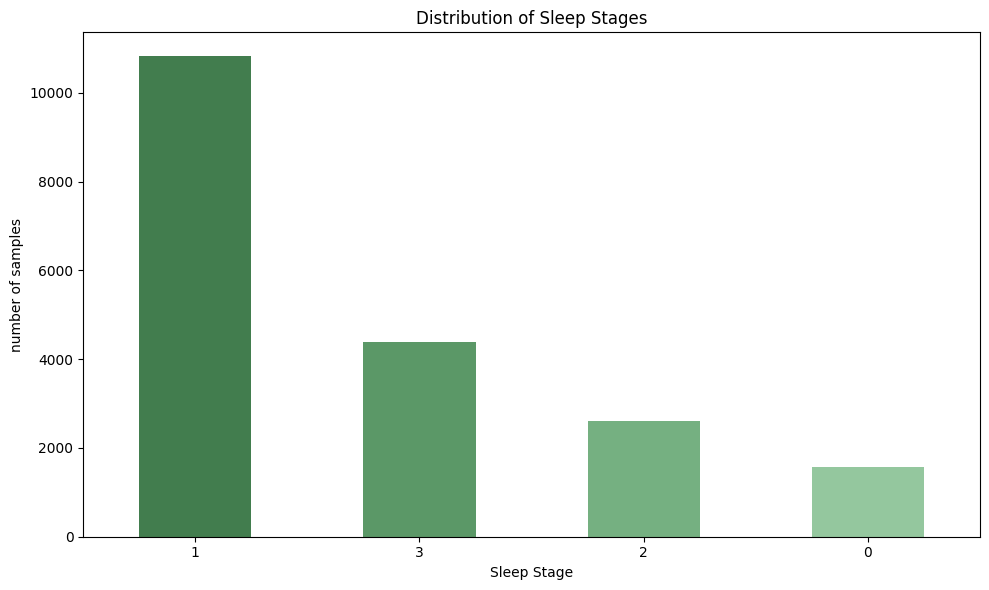

In [28]:
# Labels histogram
# Count the frequency of each sleep_stage at each time point
label_counts = filtered_data['sleep_stage'].value_counts()

# Create a color palette that goes from dark to light
palette = sns.cubehelix_palette(start=2, rot=0, dark=0.4, light=0.9, reverse=True)

# Plot the distribution of sleep stages with the color palette
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=palette)
plt.title('Distribution of Sleep Stages')
plt.xlabel('Sleep Stage')
plt.ylabel('number of samples')
plt.xticks(rotation=0)  # To keep the x labels readable
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

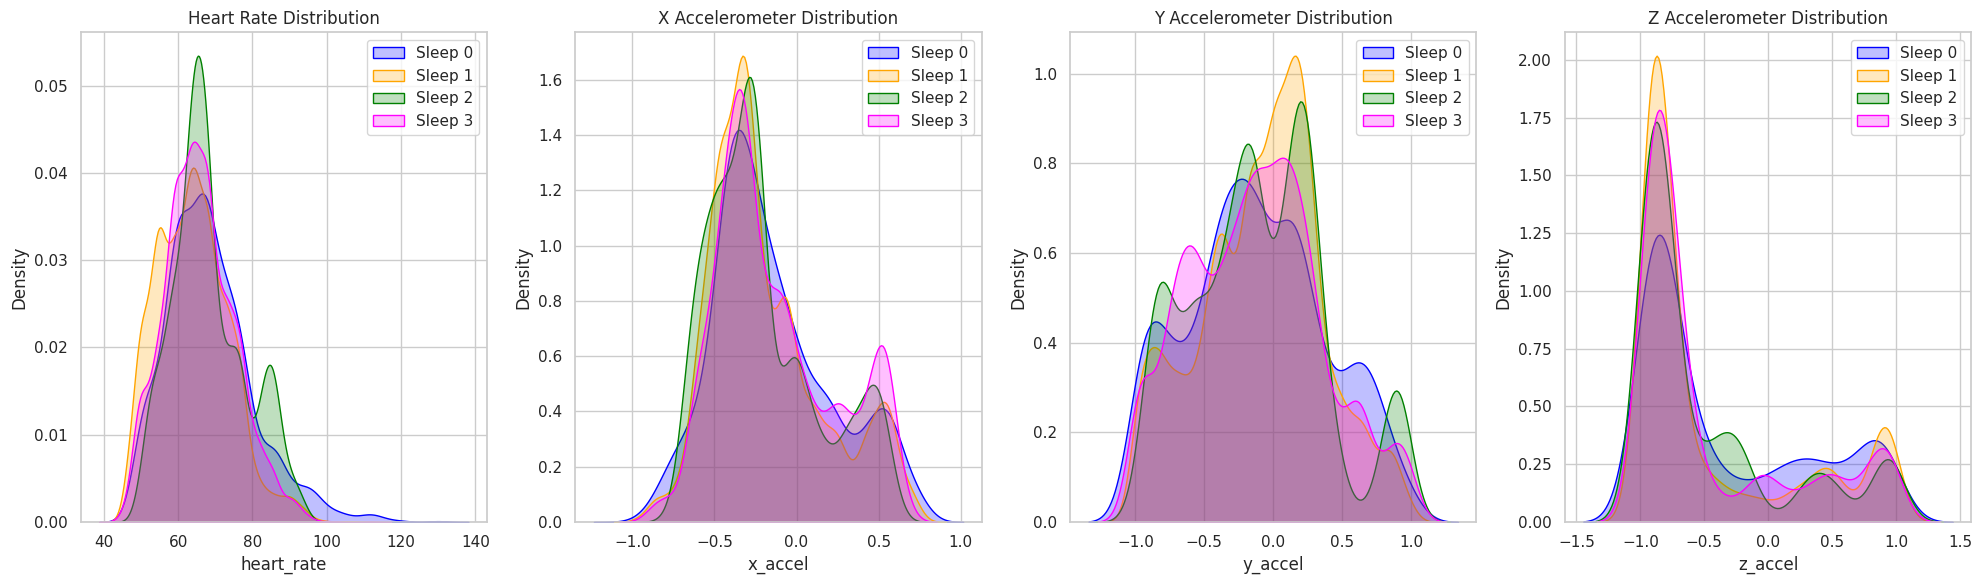

In [34]:
sleep_0=filtered_data[filtered_data['sleep_stage']==0]
sleep_1=filtered_data[filtered_data['sleep_stage']==1]
sleep_2=filtered_data[filtered_data['sleep_stage']==2]
sleep_3=filtered_data[filtered_data['sleep_stage']==3]
# Set the style for better aesthetics
sns.set(style="whitegrid")

# Create a figure with multiple subplots (1 row, 4 columns for the 4 variables)
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Plot heart rate 
sns.kdeplot(sleep_0['heart_rate'], ax=axes[0], color='blue', label='Sleep 0', fill=True)
sns.kdeplot(sleep_1['heart_rate'], ax=axes[0], color='orange', label='Sleep 1', fill=True)
sns.kdeplot(sleep_2['heart_rate'], ax=axes[0], color='green', label='Sleep 2', fill=True)
sns.kdeplot(sleep_3['heart_rate'], ax=axes[0], color='magenta', label='Sleep 3', fill=True)
axes[0].set_title('Heart Rate Distribution')
axes[0].legend()

# Plot X accelerometer 
sns.kdeplot(sleep_0['x_accel'], ax=axes[1], color='blue', label='Sleep 0', fill=True)
sns.kdeplot(sleep_1['x_accel'], ax=axes[1], color='orange', label='Sleep 1', fill=True)
sns.kdeplot(sleep_2['x_accel'], ax=axes[1], color='green', label='Sleep 2', fill=True)
sns.kdeplot(sleep_3['x_accel'], ax=axes[1], color='magenta', label='Sleep 3', fill=True)
axes[1].set_title('X Accelerometer Distribution')
axes[1].legend()

# Plot Y accelerometer 
sns.kdeplot(sleep_0['y_accel'], ax=axes[2], color='blue', label='Sleep 0', fill=True)
sns.kdeplot(sleep_1['y_accel'], ax=axes[2], color='orange', label='Sleep 1', fill=True)
sns.kdeplot(sleep_2['y_accel'], ax=axes[2], color='green', label='Sleep 2', fill=True)
sns.kdeplot(sleep_3['y_accel'], ax=axes[2], color='magenta', label='Sleep 3', fill=True)
axes[2].set_title('Y Accelerometer Distribution')
axes[2].legend()

# Plot Z accelerometer 
sns.kdeplot(sleep_0['z_accel'], ax=axes[3], color='blue', label='Sleep 0', fill=True)
sns.kdeplot(sleep_1['z_accel'], ax=axes[3], color='orange', label='Sleep 1', fill=True)
sns.kdeplot(sleep_2['z_accel'], ax=axes[3], color='green', label='Sleep 2', fill=True)
sns.kdeplot(sleep_3['z_accel'], ax=axes[3], color='magenta', label='Sleep 3', fill=True)
axes[3].set_title('Z Accelerometer Distribution')
axes[3].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [104]:
import numpy as np
from scipy.stats import kruskal

# Perform Kruskal-Wallis H test
stat, p = kruskal(sleep_1['heart_rate'], sleep_2['heart_rate'],sleep_3['heart_rate'])

# Print results
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p}")

lpha = 0.05  # significance level
if p < alpha:
        print("Reject the null hypothesis: At least one distribution is significantly different.")
else:
        print("Fail to reject the null hypothesis: The distributions are similar.")


Kruskal-Wallis Test Statistic: 381.38185742454164
P-value: 1.527502435098684e-83
Reject the null hypothesis: At least one distribution is significantly different.


In [105]:
# Perform Kruskal-Wallis H test
stat, p = kruskal(sleep_1['x_accel'], sleep_2['x_accel'],sleep_3['x_accel'])

# Print results
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p}")

lpha = 0.05  # significance level
if p < alpha:
        print("Reject the null hypothesis: At least one distribution is significantly different.")
else:
        print("Fail to reject the null hypothesis: The distributions are similar.")


Kruskal-Wallis Test Statistic: 89.27485843243747
P-value: 4.1134934020966317e-20
Reject the null hypothesis: At least one distribution is significantly different.


In [106]:
# Perform Kruskal-Wallis H test
stat, p = kruskal(sleep_1['y_accel'], sleep_2['y_accel'],sleep_3['y_accel'])

# Print results
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p}")

lpha = 0.05  # significance level
if p < alpha:
        print("Reject the null hypothesis: At least one distribution is significantly different.")
else:
        print("Fail to reject the null hypothesis: The distributions are similar.")

Kruskal-Wallis Test Statistic: 41.61676881479604
P-value: 9.184033824414941e-10
Reject the null hypothesis: At least one distribution is significantly different.


In [107]:
# Perform Kruskal-Wallis H test
stat, p = kruskal(sleep_1['z_accel'], sleep_2['z_accel'],sleep_3['z_accel'])

# Print results
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p}")

lpha = 0.05  # significance level
if p < alpha:
        print("Reject the null hypothesis: At least one distribution is significantly different.")
else:
        print("Fail to reject the null hypothesis: The distributions are similar.")

Kruskal-Wallis Test Statistic: 17.13494252105741
P-value: 0.00019019299075023337
Reject the null hypothesis: At least one distribution is significantly different.


All distribution are significantly different.

# Training

There is a clear imbalance between classes, then different approaches were tested:
1. Simple Bi-LSTM model
2. Simple Bi-LSTM model with undersampling label 1
3. Simple Bi-LSTM model with feature engineering

Create the features that are going to be used on the third model.

In [29]:
# Create features
new_df = filtered_data.copy()
# Compute the change in heart rate for each subject_id
new_df['heart_rate_change'] = new_df.groupby('subject_id')['heart_rate'].diff()

# Compute the movement magnitude
new_df['movement'] = np.sqrt(
    new_df['x_accel']**2 + 
    new_df['y_accel']**2 + 
    new_df['z_accel']**2
)

# Compute the change in movement for each subject_id
new_df['movement_change'] = new_df.groupby('subject_id')['movement'].diff()

new_df['heart_rate_change'] = new_df['heart_rate_change'].fillna(0)
new_df['movement_change'] = new_df['movement_change'].fillna(0)
new_df['change_combined'] = new_df['movement_change'] + new_df['heart_rate_change']
# Verify the updated dataset
print("\nUpdated Merged Data with Heart Rate Change and Movement Magnitude:")
new_df.head()


Updated Merged Data with Heart Rate Change and Movement Magnitude:


,sleep_stage,heart_rate,x_accel,y_accel,z_accel,subject_id,heart_rate_change,movement,movement_change,change_combined
time,,,,,,,,,,
1970-01-01 00:13:30,0,68.0,-0.712540,-0.150314,-0.676773,6220552,0.0,0.994147,0.000000,0.000000
1970-01-01 00:14:00,0,68.5,-0.711014,-0.174820,-0.672272,6220552,0.5,0.994008,-0.000139,0.499861
1970-01-01 00:14:30,0,65.0,-0.711517,-0.173325,-0.672745,6220552,-3.5,0.994426,0.000418,-3.499582
1970-01-01 00:15:00,0,66.0,-0.711548,-0.172836,-0.672287,6220552,1.0,0.994054,-0.000373,0.999627
1970-01-01 00:15:30,0,66.0,-0.709549,-0.175308,-0.672302,6220552,0.0,0.993067,-0.000986,-0.000986


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

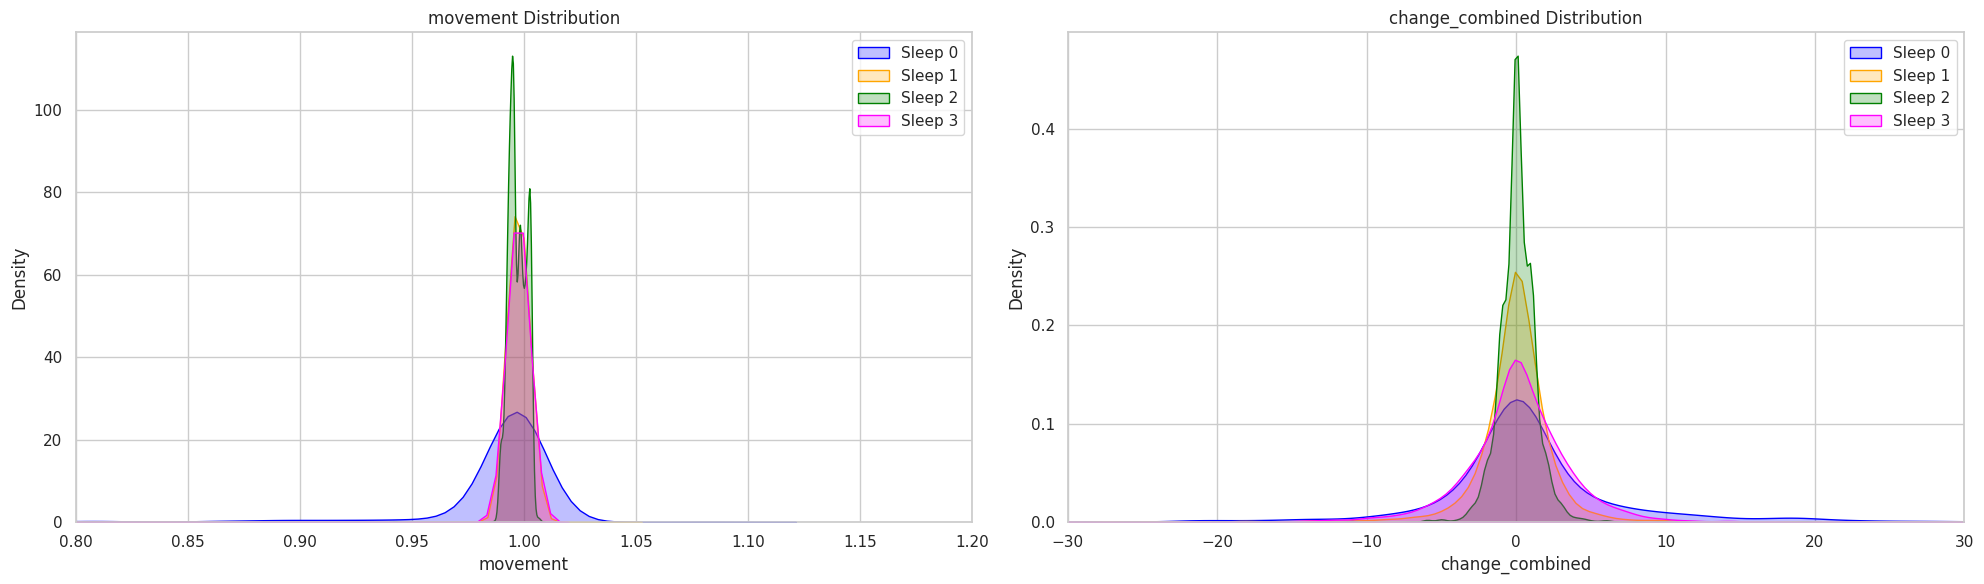

In [60]:
sleep_0=new_df[new_df['sleep_stage']==0]
sleep_1=new_df[new_df['sleep_stage']==1]
sleep_2=new_df[new_df['sleep_stage']==2]
sleep_3=new_df[new_df['sleep_stage']==3]
# Set the style
sns.set(style="whitegrid")

# Create a figure with multiple subplots 
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot movement distribution
sns.kdeplot(sleep_0['movement'], ax=axes[0], color='blue', label='Sleep 0', fill=True)
sns.kdeplot(sleep_1['movement'], ax=axes[0], color='orange', label='Sleep 1', fill=True)
sns.kdeplot(sleep_2['movement'], ax=axes[0], color='green', label='Sleep 2', fill=True)
sns.kdeplot(sleep_3['movement'], ax=axes[0], color='magenta', label='Sleep 3', fill=True)
axes[0].set_title('movement Distribution')
axes[0].legend()

# Set custom x-axis limits for 'movement'
axes[0].set_xlim([0.8,1.2])  

# Plot change_combined distribution
sns.kdeplot(sleep_0['change_combined'], ax=axes[1], color='blue', label='Sleep 0', fill=True)
sns.kdeplot(sleep_1['change_combined'], ax=axes[1], color='orange', label='Sleep 1', fill=True)
sns.kdeplot(sleep_2['change_combined'], ax=axes[1], color='green', label='Sleep 2', fill=True)
sns.kdeplot(sleep_3['change_combined'], ax=axes[1], color='magenta', label='Sleep 3', fill=True)
axes[1].set_title('change_combined Distribution')
axes[1].legend()

# Set custom x-axis limits for 'change_combined'
axes[1].set_xlim([-30, 30])  

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [35]:
# Group the data by subject_id
grouped_data = new_df.groupby('subject_id')

# Get a list of all unique subject_ids
subject_ids = new_df['subject_id'].unique()

# Split the subject_ids into training, validation, and test sets
train_subjects, test_subjects = train_test_split(subject_ids, test_size=4, random_state=42)  
train_subjects, val_subjects = train_test_split(train_subjects, test_size=4, random_state=42) 

# Filter the data by the subject_ids for each set
train_data = new_df[new_df['subject_id'].isin(train_subjects)]
val_data = new_df[new_df['subject_id'].isin(val_subjects)]
test_data = new_df[new_df['subject_id'].isin(test_subjects)]

# Print the sizes of each dataset
print(f"Train data size: {train_data.shape}")
print(f"Validation data size: {val_data.shape}")
print(f"Test data size: {test_data.shape}")

print(len(train_data['subject_id'].unique()))
print(len(val_data['subject_id'].unique()))
print(len(test_data['subject_id'].unique()))


Train data size: (12031, 10)
Validation data size: (3778, 10)
Test data size: (3590, 10)
15
4
4


In [36]:
# Normalize features for model 1 and 2
train_norm = train_data.iloc[:,[0,1,2,3,4]]
val_norm = val_data.iloc[:,[0,1,2,3,4]]
test_norm = test_data.iloc[:,[0,1,2,3,4]]
# Select features to normalize
features_to_normalize = ['heart_rate', 'x_accel', 'y_accel', 'z_accel']
scaler = MinMaxScaler()
train_norm[features_to_normalize] = scaler.fit_transform(train_norm[features_to_normalize])
val_norm[features_to_normalize] = scaler.fit_transform(val_norm[features_to_normalize])
test_norm[features_to_normalize] = scaler.fit_transform(test_norm[features_to_normalize])

print(f'train data max time:{train_norm.index.max()}, min: {train_norm.index.min()}')
print(f'validation data max time:{val_norm.index.max()}, min: {val_norm.index.min()}')
print(f'test data max time:{test_norm.index.max()}, min: {test_norm.index.min()}')

train data max time:1970-01-01 08:09:30, min: 1970-01-01 00:00:00
validation data max time:1970-01-01 08:10:00, min: 1970-01-01 00:00:00
test data max time:1970-01-01 08:11:00, min: 1970-01-01 00:05:30


/tmp/ipykernel_23/1748601681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_norm[features_to_normalize] = scaler.fit_transform(train_norm[features_to_normalize])
/tmp/ipykernel_23/1748601681.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_norm[features_to_normalize] = scaler.fit_transform(val_norm[features_to_normalize])
/tmp/ipykernel_23/1748601681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [37]:
# Reshape the dataset into (num_samples, sequence_length, num_features)
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length, 1:].values  # All features except the label
        label = data.iloc[i:i+sequence_length, 0].values  # Labels for all timesteps
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# features and labels
sequence_length = 12 
features = train_data[['heart_rate', 'x_accel', 'y_accel', 'z_accel']]
labels = train_data['sleep_stage']


X_train, y_train = create_sequences(train_norm, sequence_length)
X_val, y_val = create_sequences(val_norm, sequence_length)
X_test, y_test = create_sequences(test_norm, sequence_length)

print("X_train shape:", X_train.shape)  # (num_samples, sequence_length, num_features)
print("y_train shape:", y_train.shape)  # (num_samples, sequence_length)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12019, 12, 4)
y_train shape: (12019, 12)
X_val shape: (3766, 12, 4)
y_val shape: (3766, 12)
X_test shape: (3578, 12, 4)
y_test shape: (3578, 12)


In [38]:
# Normalize features for model 3, with new features
train_norm2 = train_data.iloc[:,[0,1,7,9]]
val_norm2 = val_data.iloc[:,[0,1,7,9]]
test_norm2 = test_data.iloc[:,[0,1,7,9]]
# Select features to normalize
features_to_normalize = ['heart_rate','movement','change_combined']
scaler = MinMaxScaler()
train_norm2[features_to_normalize] = scaler.fit_transform(train_norm2[features_to_normalize])
val_norm2[features_to_normalize] = scaler.fit_transform(val_norm2[features_to_normalize])
test_norm2[features_to_normalize] = scaler.fit_transform(test_norm2[features_to_normalize])
# Reshape the dataset into (num_samples, sequence_length, num_features)

sequence_length = 12
features2 = train_data[['heart_rate','movement','change_combined']]
labels2 = train_data['sleep_stage']


X_train2, y_train2 = create_sequences(train_norm2, sequence_length)
X_val2, y_val2 = create_sequences(val_norm2, sequence_length)
X_test2, y_test2 = create_sequences(test_norm2, sequence_length)

print("X_train shape:", X_train2.shape)  # (num_samples, sequence_length, num_features)
print("y_train shape:", y_train2.shape)  # (num_samples, sequence_length)
print("X_val shape:", X_val2.shape)
print("y_val shape:", y_val2.shape)
print("X_test shape:", X_test2.shape)
print("y_test shape:", y_test2.shape)

/tmp/ipykernel_23/1973622380.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_norm2[features_to_normalize] = scaler.fit_transform(train_norm2[features_to_normalize])
/tmp/ipykernel_23/1973622380.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_norm2[features_to_normalize] = scaler.fit_transform(val_norm2[features_to_normalize])
/tmp/ipykernel_23/1973622380.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

X_train shape: (12019, 12, 3)
y_train shape: (12019, 12)
X_val shape: (3766, 12, 3)
y_val shape: (3766, 12)
X_test shape: (3578, 12, 3)
y_test shape: (3578, 12)


**Simple Bi-LSTM model**

In [39]:
model2 = Sequential()

# Bidirectional LSTM layer with 'return_sequences=True' to output a sequence of vectors
model2.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))

# Dropout layer
model2.add(Dropout(0.2))

# Dense layer 
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))  

# Output layer
model2.add(Dense(4, activation='softmax'))  # for multi-class classification

# Compile
optimizer = Adam(learning_rate=0.001)
model2.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=False),  
    metrics=['accuracy']
)


model2.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

# Train the model
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    shuffle=False,  # Maintain sequence order
    verbose=1
    ,callbacks=[early_stopping, reduce_lr])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 256)        │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12, 4)          │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,604 (662.52 KB)

 Trainable params: 169,604 (662.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5332 - loss: 1.2546 - val_accuracy: 0.6216 - val_loss: 1.1030 - learning_rate: 0.0010
Epoch 2/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5600 - loss: 1.1804 - val_accuracy: 0.6216 - val_loss: 1.0878 - learning_rate: 0.0010
Epoch 3/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5600 - loss: 1.1703 - val_accuracy: 0.6216 - val_loss: 1.0877 - learning_rate: 0.0010
Epoch 4/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5600 - loss: 1.1723 - val_accuracy: 0.6216 - val_loss: 1.0841 - learning_rate: 0.0010
Epoch 5/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5600 - loss: 1.1673 - val_accuracy: 0.6216 - val_loss: 1.0933 - learning_rate: 0.0010
Epoch 6/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5600 - loss: 1.1663 - val_accuracy: 0.6216 - val_loss: 1.0902 - learning_rate: 0.0010
Epoch 7/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5600 - loss: 1.

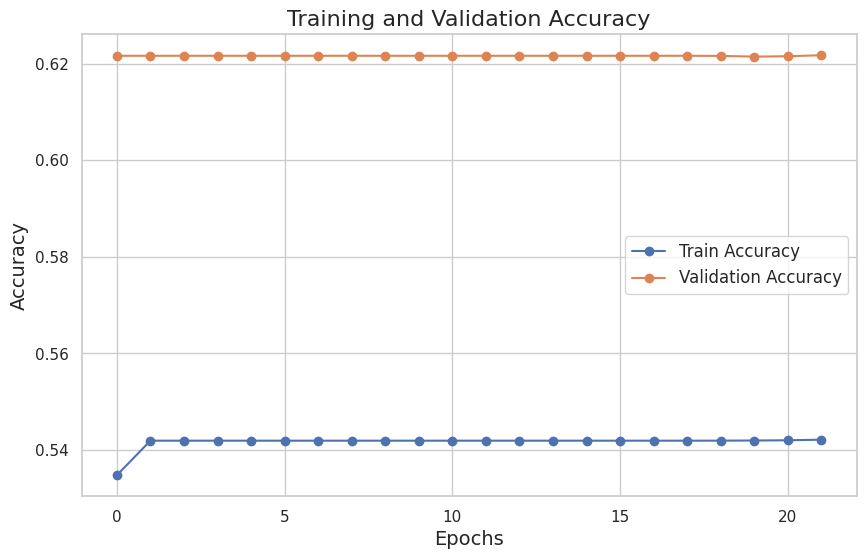

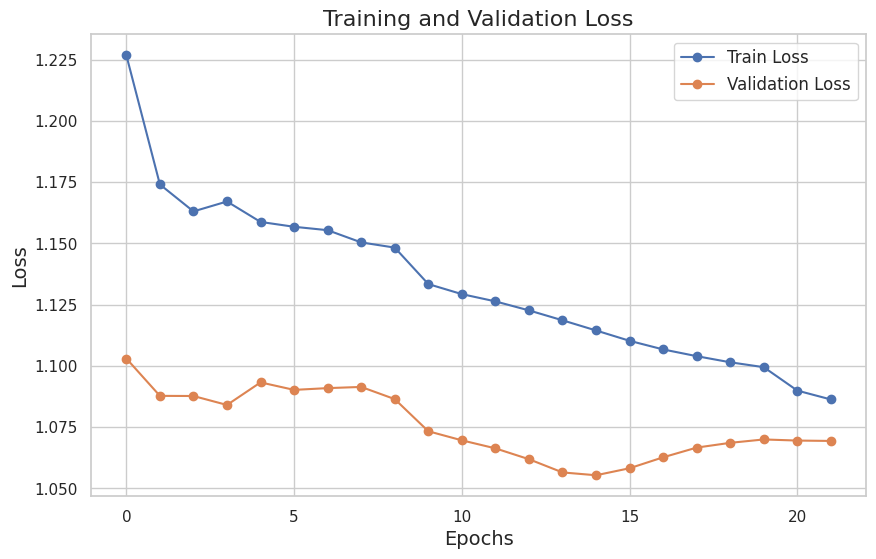

In [40]:
# Extract history data
history_data = history2.history

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_data['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history_data['loss'], label='Train Loss', marker='o')
plt.plot(history_data['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [41]:
# Get predictions and reshape as needed
y_pred2 = model2.predict(X_val)
y_pred_classes2 = np.argmax(y_pred2, axis=-1)  # Convert probabilities to class indices

# Flatten both predictions and true labels for scoring
y_pred_flat2 = y_pred_classes2.flatten()
y_true_flat = y_val.flatten()

# Compute F1 score
f1_scores2 = f1_score(y_val.flatten(), y_pred_classes2.flatten(), average=None)  
print("F1 Score:", f1_scores2)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
F1 Score: [0.         0.76666121 0.         0.        ]


**Simple Bi-LSTM model with undersampling label 1**

In [42]:
# Identify the indices of sequences where the label at any time step is class 1
class_1_sequences = [i for i in range(len(y_train)) if np.any(y_train[i] == 1)]

# Number of sequences to keep for class 1 (e.g., 50% of class 1 sequences)
num_class_1_to_keep = int(len(class_1_sequences) * 0.5)  # Keep 50% of class 1 sequences

# Randomly sample indices to keep for class 1
np.random.seed(42)  # For reproducibility
class_1_indices_to_keep = np.random.choice(class_1_sequences, size=num_class_1_to_keep, replace=False)

# Filter out the sequences for class 1
X_train_class_1 = X_train[class_1_indices_to_keep]
y_train_class_1 = y_train[class_1_indices_to_keep]

# Filter the other sequences (class != 1)
X_train_other_classes = X_train[np.all(y_train != 1, axis=1)]
y_train_other_classes = y_train[np.all(y_train != 1, axis=1)]

# Concatenate the filtered sequences
X_train_filtered = np.concatenate([X_train_class_1, X_train_other_classes], axis=0)
y_train_filtered = np.concatenate([y_train_class_1, y_train_other_classes], axis=0)

# Shuffle the filtered data to mix sequences
indices = np.arange(len(y_train_filtered))
np.random.shuffle(indices)

X_train_filtered = X_train_filtered[indices]
y_train_filtered = y_train_filtered[indices]

# Check the final shapes
print("Filtered X_train shape:", X_train_filtered.shape)  # Should be (num_samples, sequence_length, num_features)
print("Filtered y_train shape:", y_train_filtered.shape)  # Should be (num_samples, sequence_length)


Filtered X_train shape: (7806, 12, 4)
Filtered y_train shape: (7806, 12)


In [43]:
model4 = Sequential()

# Bidirectional LSTM layer with 'return_sequences=True' to output a sequence of vectors
model4.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
# Dropout layer
model4.add(Dropout(0.2))
# Dense layer
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.2))  
# Output layer
model4.add(Dense(4, activation='softmax'))  # for multi-class classification

# Compile

model4.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=False),  
    metrics=['accuracy']
)


model4.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
history4 = model4.fit(
    X_train_filtered, y_train_filtered,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    shuffle=False,  # Maintain sequence order
    verbose=1
    ,callbacks=[early_stopping, reduce_lr])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 12, 256)        │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12, 4)          │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,604 (662.52 KB)

 Trainable params: 169,604 (662.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4125 - loss: 1.2474 - val_accuracy: 0.3821 - val_loss: 1.2124 - learning_rate: 0.0010
Epoch 2/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4698 - loss: 1.1762 - val_accuracy: 0.3766 - val_loss: 1.3581 - learning_rate: 0.0010
Epoch 3/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4974 - loss: 1.1333 - val_accuracy: 0.3757 - val_loss: 1.3877 - learning_rate: 0.0010
Epoch 4/100
486/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5145 - loss: 1.0968
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5146 - loss: 1.0967 - val_accuracy: 0.3896 - val_loss: 1.4382 - learning_rate: 0.0010
Epoch 5/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5447 - loss: 1.0384 - val_accuracy: 0.3935 - val_loss: 1.5130 - learning_rate: 2.0000e-04
Epoch 6/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5554 - loss:

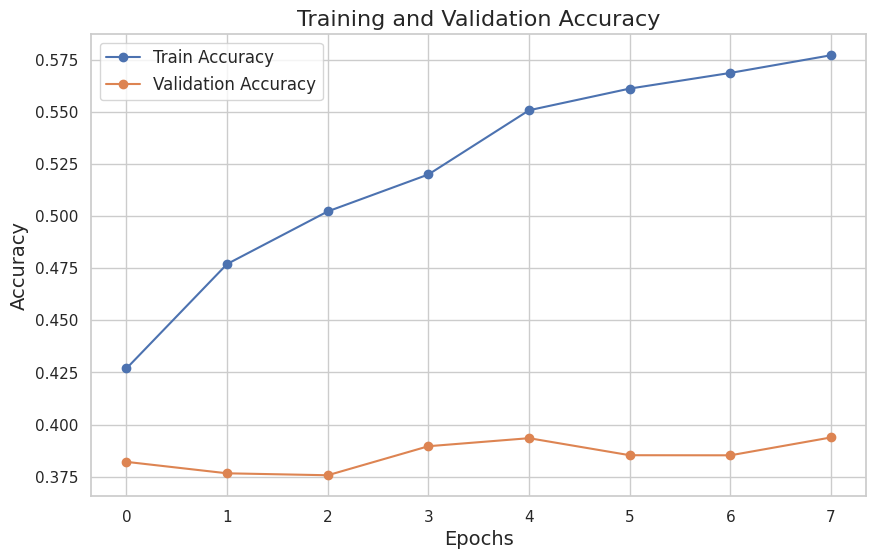

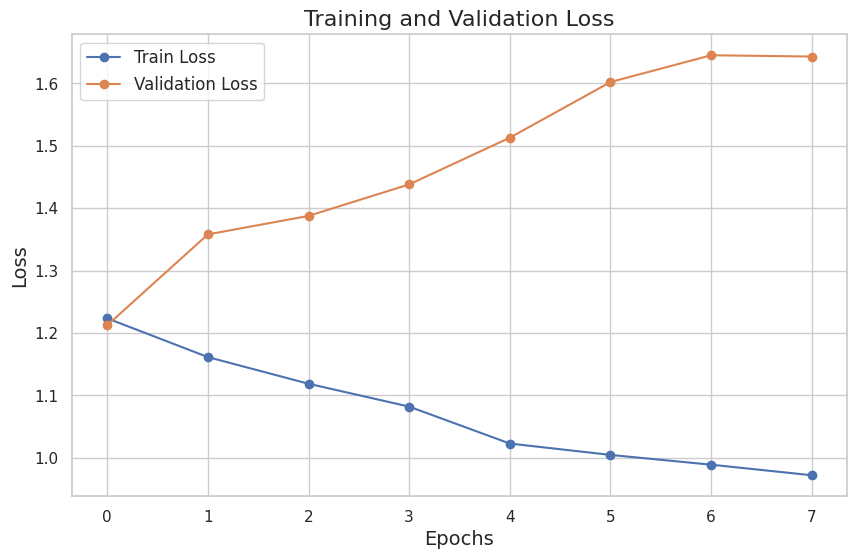

In [44]:
# Extract history data
history_data = history4.history

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_data['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history_data['loss'], label='Train Loss', marker='o')
plt.plot(history_data['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [45]:
# Get predictions and reshape as needed
y_pred4 = model4.predict(X_val)
y_pred_classes4 = np.argmax(y_pred4, axis=-1)  # Convert probabilities to class indices

f1_scores4 = f1_score(y_val.flatten(), y_pred_classes4.flatten(), average=None)  
print("F1 Score:", f1_scores4)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
F1 Score: [0.10534375 0.53257501 0.23071412 0.17561278]


**Simple Bi-LSTM model with feature engineering**

In [46]:
model8 = Sequential()

# Bidirectional LSTM layer with 'return_sequences=True' to output a sequence of vectors
model8.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train2.shape[1], X_train2.shape[2])))

# Dropout layer 
model8.add(Dropout(0.2))
#  Dense layer
model8.add(Dense(128, activation='relu'))
model8.add(Dropout(0.2))  


# Output layer
model8.add(Dense(4, activation='softmax'))  # for multi-class classification

# Compile 
model8.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=False),  
    metrics=['accuracy']
)


model8.summary()

# Train the model
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history8 = model8.fit(
    X_train2, y_train2,
    validation_data=(X_val2, y_val2),
    epochs=100,
    batch_size=16,
    shuffle=False,  # Maintain sequence order
    verbose=1,
    callbacks=[early_stopping, reduce_lr])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 12, 256)        │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12, 4)          │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,580 (658.52 KB)

 Trainable params: 168,580 (658.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5369 - loss: 1.2328 - val_accuracy: 0.6216 - val_loss: 1.1171 - learning_rate: 0.0010
Epoch 2/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5600 - loss: 1.1741 - val_accuracy: 0.6216 - val_loss: 1.1112 - learning_rate: 0.0010
Epoch 3/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5560 - loss: 1.1709 - val_accuracy: 0.6216 - val_loss: 1.1119 - learning_rate: 0.0010
Epoch 4/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5600 - loss: 1.1697 - val_accuracy: 0.6248 - val_loss: 1.1162 - learning_rate: 0.0010
Epoch 5/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5597 - loss: 1.1672 - val_accuracy: 0.6216 - val_loss: 1.1019 - learning_rate: 0.0010
Epoch 6/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5600 - loss: 1.1629 - val_accuracy: 0.6216 - val_loss: 1.1001 - learning_rate: 0.0010
Epoch 7/100
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5598 - loss: 1.

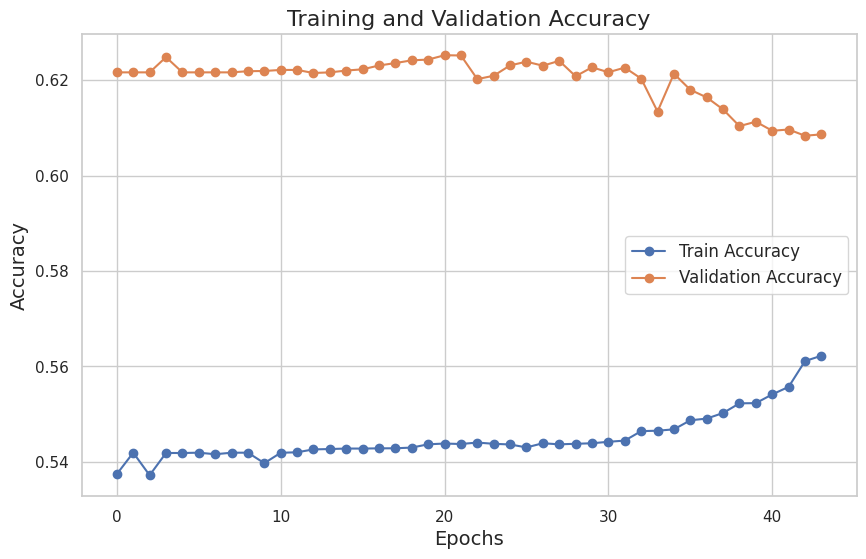

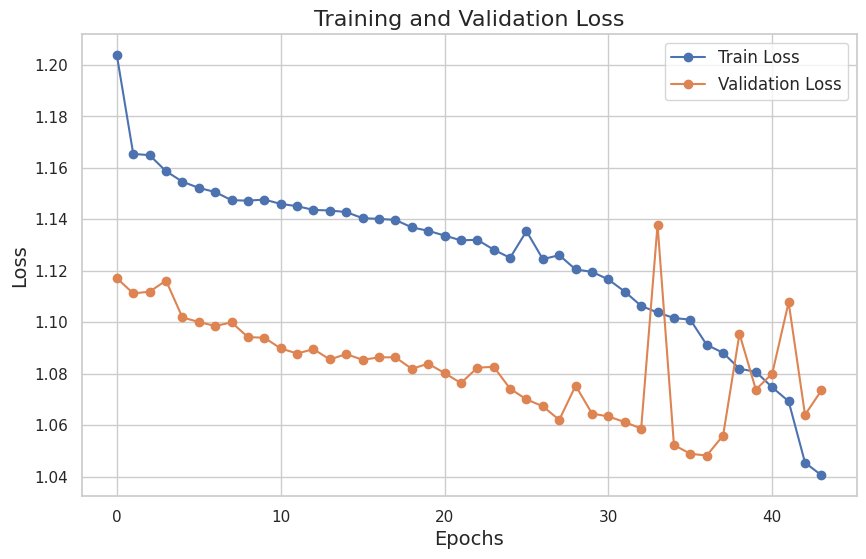

In [47]:
# Extract history data
history_data = history8.history

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_data['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history_data['loss'], label='Train Loss', marker='o')
plt.plot(history_data['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [48]:
# Get predictions and reshape as needed
y_pred8 = model8.predict(X_val2)
y_pred_classes8 = np.argmax(y_pred8, axis=-1)  # Convert probabilities to class indices

f1_scores8 = f1_score(y_val2.flatten(), y_pred_classes8.flatten(), average=None)  
print("F1 Score:", f1_scores8)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
F1 Score: [0.23510174 0.76092852 0.00116482 0.19951556]


# Evaluation

In [49]:
# Compute average F1 score
print('-------------------simple BiLSTM with dropout--------------------')
average_f1_score2 = np.mean(f1_scores2)
print("Average F1 Score:", average_f1_score2)

print('-------------------simple BiLSTM with unddersampling--------------------')
average_f1_score4 = np.mean(f1_scores4)
print("Average F1 Score:", average_f1_score4)
print('-------------------simple BiLSTM with feature engineering--------------------')

average_f1_score8 = np.mean(f1_scores8)
print("Average F1 Score:", average_f1_score8)



-------------------simple BiLSTM with dropout--------------------
Average F1 Score: 0.1916653021123301
-------------------simple BiLSTM with unddersampling--------------------
Average F1 Score: 0.2610614145408582
-------------------simple BiLSTM with feature engineering--------------------
Average F1 Score: 0.2991776636989655


The three models show that combining the accelerometer data and calculating changes in movement and heart rate improves the model without losing information, unlike in the undersampling case.

In general, it was also noticed that the dropout helped reduce the overfitting of the label 1.

**Evaluation on validation data:**

In [61]:
# Compute precision and recall for each class
precision_scores = precision_score(y_val2.flatten(), y_pred_classes8.flatten(), average=None)
recall_scores = recall_score(y_val2.flatten(), y_pred_classes8.flatten(), average=None)

# Print precision and recall for each class
print("Precision Scores for each class:", precision_scores)
print("Recall Scores for each class:", recall_scores)

# Compute average precision and recall
average_precision = precision_score(y_val2.flatten(), y_pred_classes8.flatten(), average='macro')
average_recall = recall_score(y_val2.flatten(), y_pred_classes8.flatten(), average='macro')

# Print average precision and recall
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Precision Scores for each class: [0.44133697 0.64443072 0.05882353 0.34913658]
Recall Scores for each class: [1.60227836e-01 9.28840951e-01 5.88235294e-04 1.39663401e-01]
Average Precision: 0.3734319505264626
Average Recall: 0.3073301057930596


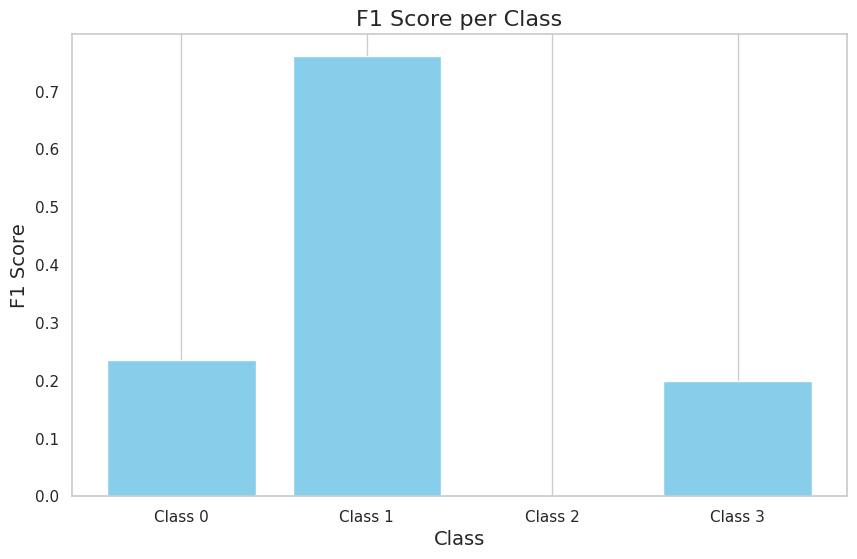

In [62]:
# Compute F1 scores for each class
# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(f1_scores8)), f1_scores8, color='skyblue')
plt.title('F1 Score per Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(np.arange(len(f1_scores8)), [f'Class {i}' for i in range(len(f1_scores8))])
plt.grid(axis='y')
plt.show()

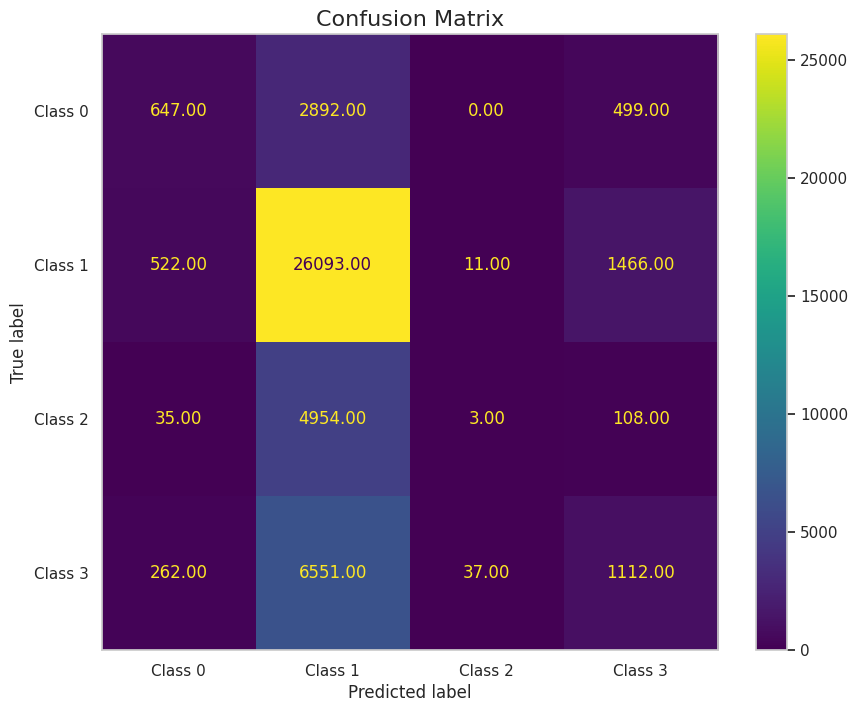

In [63]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_val.flatten(), y_pred_classes8.flatten())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f'Class {i}' for i in range(conf_matrix.shape[0])])
disp.plot(cmap='viridis', values_format='.2f', ax=plt.gca())  # Normalized values are optional
plt.title('Confusion Matrix', fontsize=16)
plt.grid(False)
plt.show()

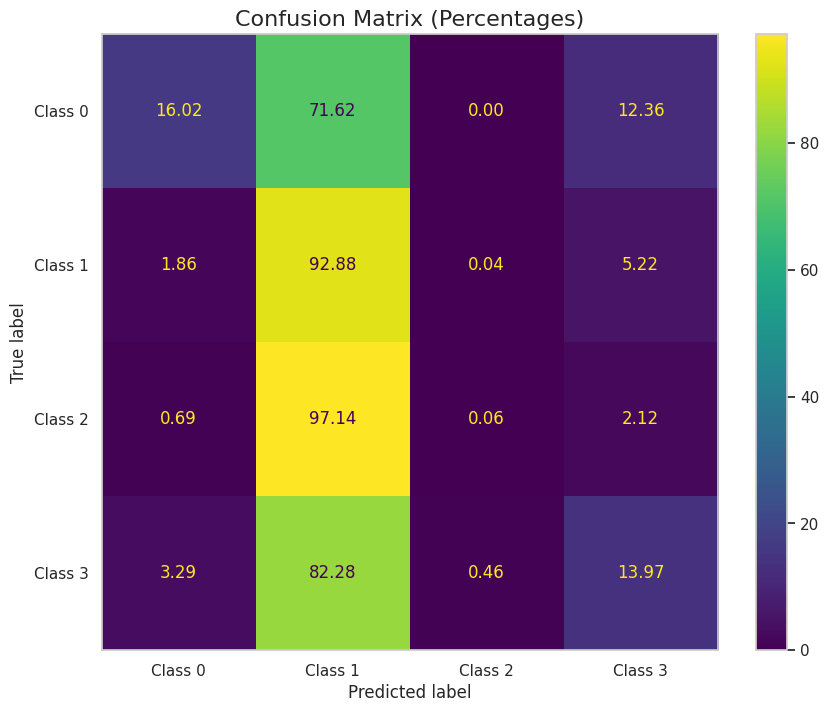

In [64]:
# Compute confusion matrix
# Normalize confusion matrix by row (true classes) to get percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, 
                              display_labels=[f'Class {i}' for i in range(conf_matrix.shape[0])])
disp.plot(cmap='viridis', values_format='.2f', ax=plt.gca())  # Display percentages with 2 decimal places
plt.title('Confusion Matrix (Percentages)', fontsize=16)
plt.grid(False)
plt.show()

In [65]:
# Predicted classes
y_pred_classes = np.argmax(y_pred8, axis=-1)  # Shape: (num_sequences, sequence_length)
y_pred_flat = y_pred_classes.flatten()  # Shape: (num_sequences * sequence_length,)
print(len(y_pred_classes))
print(len(y_pred_flat))

3766
45192


In [69]:
# Indices 
val_data_original= val_data.iloc[:-12]
#val_data_original.reset_index(drop=True, inplace=True)

# Create the sequence indices used for the model
sequence_length = X_val.shape[1]
sequences = []

for i in range(len(val_data_original) - sequence_length + 1):
    sequences.append(val_data_original.iloc[i : i + sequence_length])

# Flatten back to the original row indices
sequence_indices = np.concatenate([range(i, i + sequence_length) for i in range(len(val_data_original) - sequence_length + 1)])

In [70]:
# Combine predictions with the original data
val_data_with_predictions = val_data_original.iloc[sequence_indices].copy()
val_data_with_predictions['predicted_class'] = y_pred_flat[:len(val_data_with_predictions)]

val_data_with_predictions.head()

,sleep_stage,heart_rate,x_accel,y_accel,z_accel,subject_id,heart_rate_change,movement,movement_change,change_combined,predicted_class
time,,,,,,,,,,,
1970-01-01 00:00:00,0,63.5,-0.301376,-0.191894,-0.931755,781756,0.0,0.997907,0.000000,0.000000,3
1970-01-01 00:00:30,0,54.5,-0.301849,-0.206589,-0.930786,781756,-9.0,1.000077,0.002170,-8.997830,1
1970-01-01 00:01:00,0,50.0,-0.298904,-0.202728,-0.932709,781756,-4.5,1.000194,0.000117,-4.499883,1
1970-01-01 00:01:30,0,48.0,-0.298401,-0.199753,-0.933685,781756,-2.0,1.000356,0.000162,-1.999838,1
1970-01-01 00:02:00,0,49.0,-0.297913,-0.196854,-0.933685,781756,1.0,0.999636,-0.000721,0.999279,1


/tmp/ipykernel_23/2699659533.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')  # Get the colormap


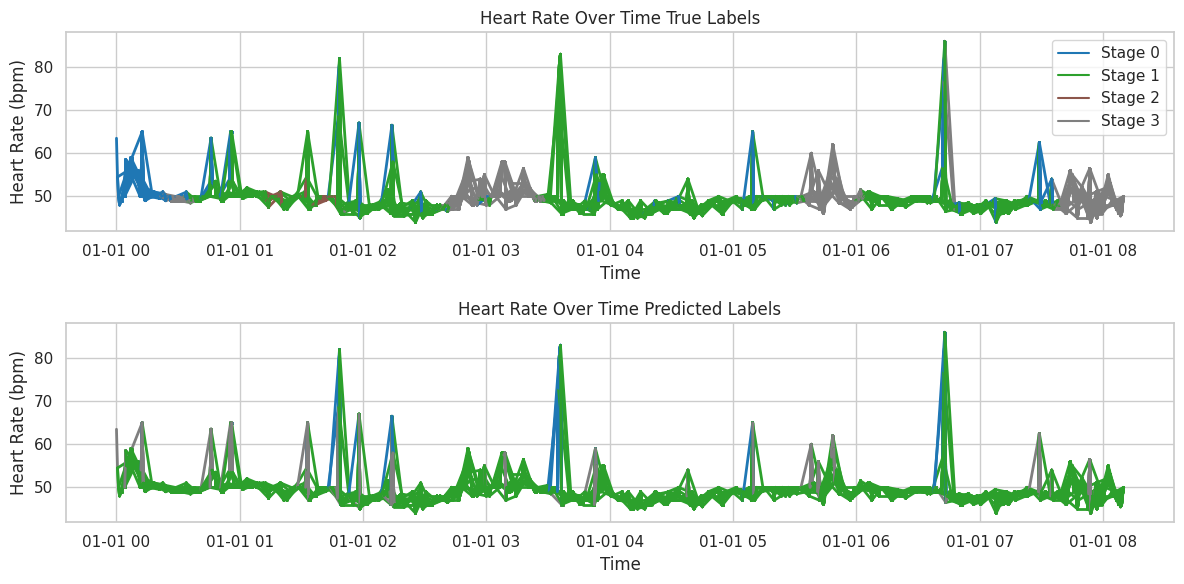

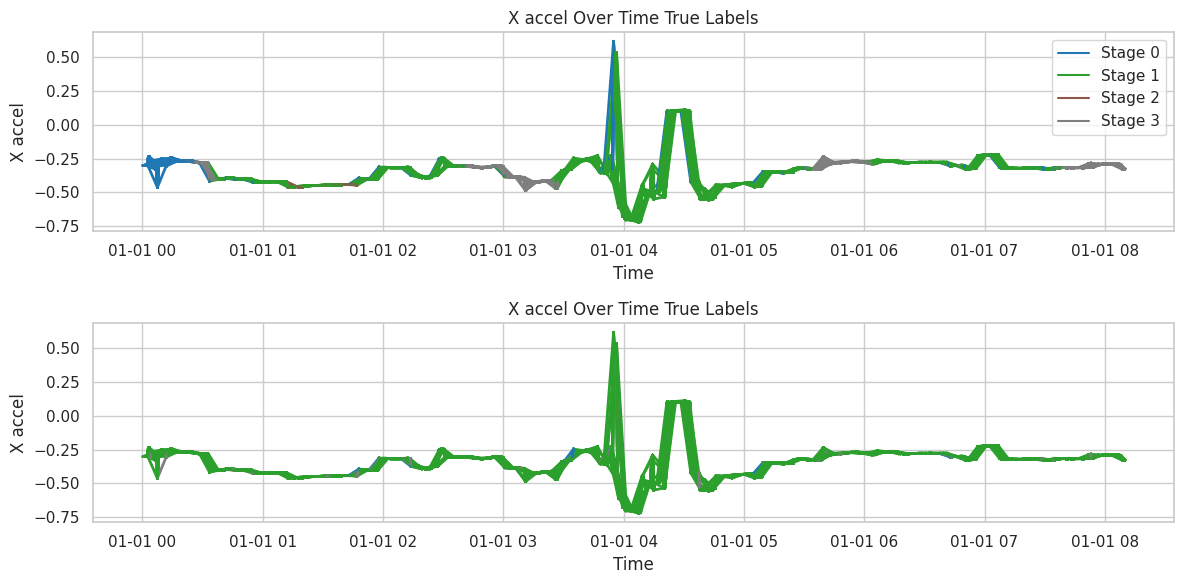

/tmp/ipykernel_23/2699659533.py:155: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


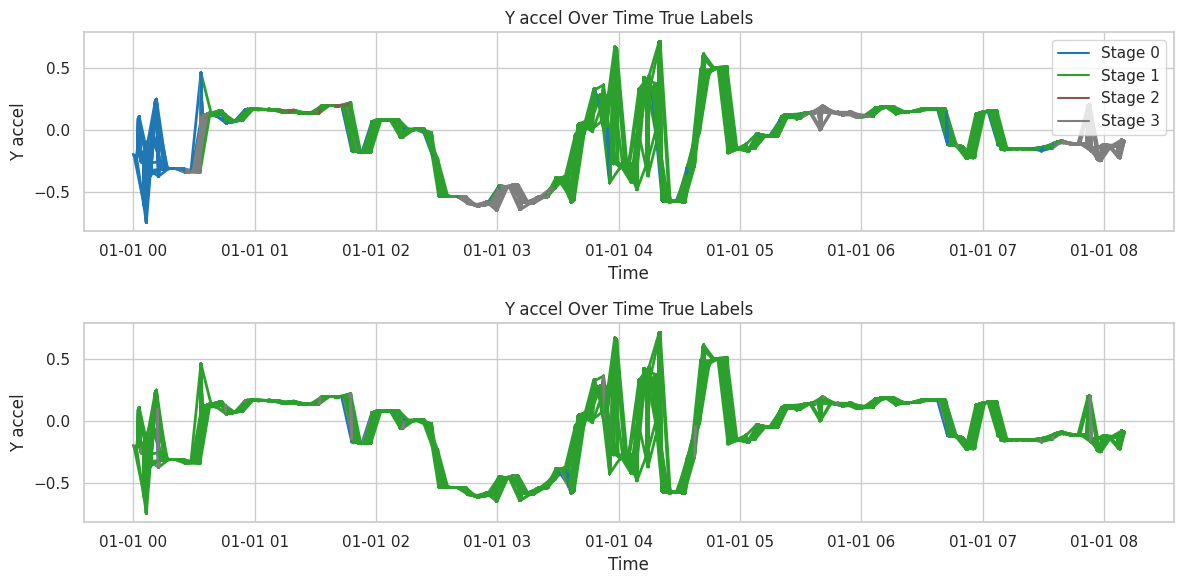

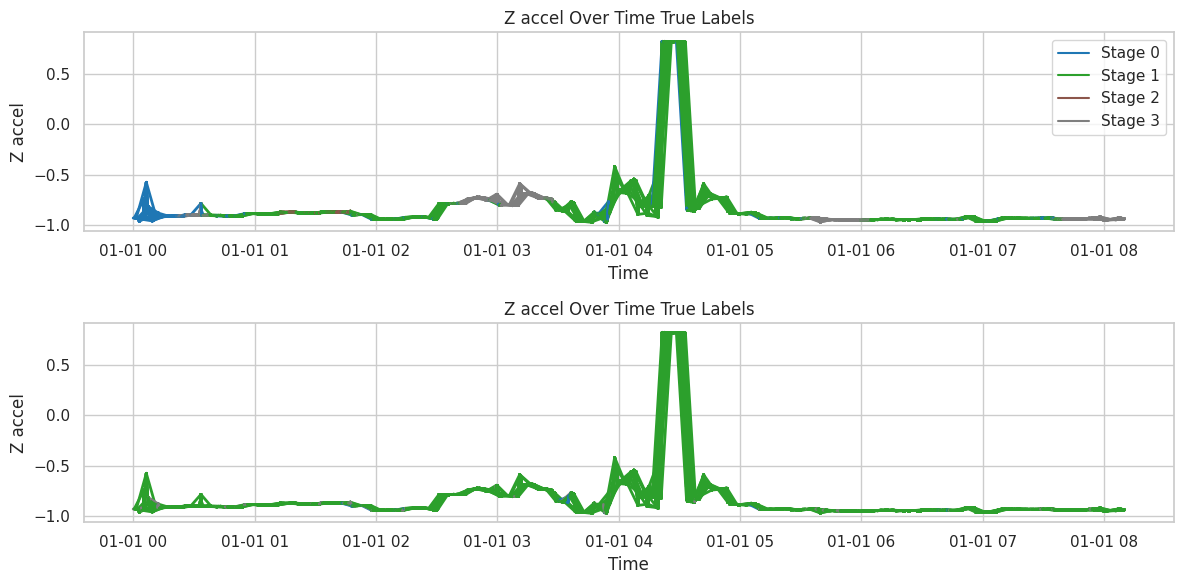

In [71]:
# Create a color map for the sleep stages
sub_data = val_data_with_predictions[val_data_with_predictions['subject_id']=='781756']

unique_stages = sub_data['sleep_stage'].unique()
cmap = plt.cm.get_cmap('tab10')  # Get the colormap
stage_to_color = {stage: cmap(i / len(unique_stages)) for i, stage in enumerate(sorted(unique_stages))}

# Extract data
heart_rate = sub_data['heart_rate'].values
x_accel = sub_data['x_accel'].values
y_accel = sub_data['y_accel'].values
z_accel = sub_data['z_accel'].values
sleep_stage = sub_data['sleep_stage'].values
predicted_class = sub_data['predicted_class'].values
time = sub_data.index.values  # Time as a NumPy array for iteration

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [heart_rate[i], heart_rate[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Heart Rate Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [heart_rate[i], heart_rate[i + 1]],
        color=stage_to_color[predicted_class[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Heart Rate Over Time Predicted Labels')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
#plt.legend()
plt.grid(True)


#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#------------
# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [x_accel[i], x_accel[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('X accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('X accel')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [x_accel[i], x_accel[i + 1]],
        color=stage_to_color[predicted_class[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('X accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('X accel')
plt.grid(True)


#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#------
# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [y_accel[i], y_accel[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Y accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Y accel')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [y_accel[i], y_accel[i + 1]],
        color=stage_to_color[predicted_class[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Y accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Y accel')
#plt.legend()
plt.grid(True)


#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [z_accel[i], z_accel[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Z accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Z accel')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [z_accel[i], z_accel[i + 1]],
        color=stage_to_color[predicted_class[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Z accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Z accel')

plt.grid(True)



plt.grid(True)
plt.tight_layout()
plt.show()



**Evaluation on test data**

In [73]:
# Get predictions and reshape as needed
y_pred_test = model8.predict(X_test2)
y_pred_classes_test = np.argmax(y_pred_test, axis=-1)  
# Compute precision and recall for each class
precision_scores = precision_score(y_test.flatten(), y_pred_classes_test.flatten(), average=None)
recall_scores = recall_score(y_test.flatten(), y_pred_classes_test.flatten(), average=None)

# Print precision and recall for each class
print("Precision Scores for each class:", precision_scores)
print("Recall Scores for each class:", recall_scores)

# Compute average precision and recall
average_precision = precision_score(y_test.flatten(), y_pred_classes_test.flatten(), average='macro')
average_recall = recall_score(y_test.flatten(), y_pred_classes_test.flatten(), average='macro')

# Print average precision and recall
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)


f1_scores8 = f1_score(y_test.flatten(), y_pred_classes_test.flatten(), average=None)  
print("F1 Score:", f1_scores8)
average_f1_score = np.mean(f1_scores8)
print("Average F1 Score:", average_f1_score8)

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precision Scores for each class: [0.85747126 0.56118894 0.         0.2795858 ]
Recall Scores for each class: [0.10590574 0.96274161 0.         0.07319907]
Average Precision: 0.42456150098992895
Average Recall: 0.2854616032975342
F1 Score: [0.18852666 0.70906111 0.         0.1160221 ]
Average F1 Score: 0.2991776636989655


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


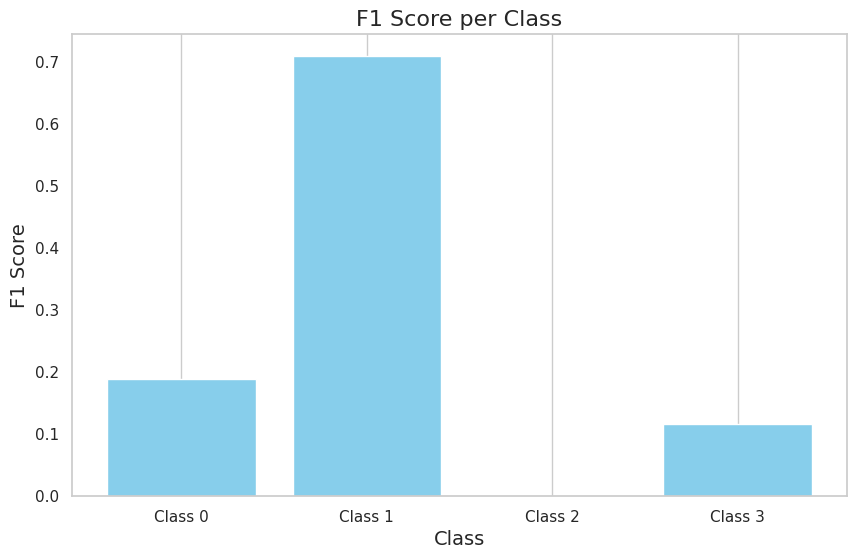

In [74]:
# Compute F1 scores for each class
# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(f1_scores8)), f1_scores8, color='skyblue')
plt.title('F1 Score per Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(np.arange(len(f1_scores8)), [f'Class {i}' for i in range(len(f1_scores8))])
plt.grid(axis='y')
plt.show()

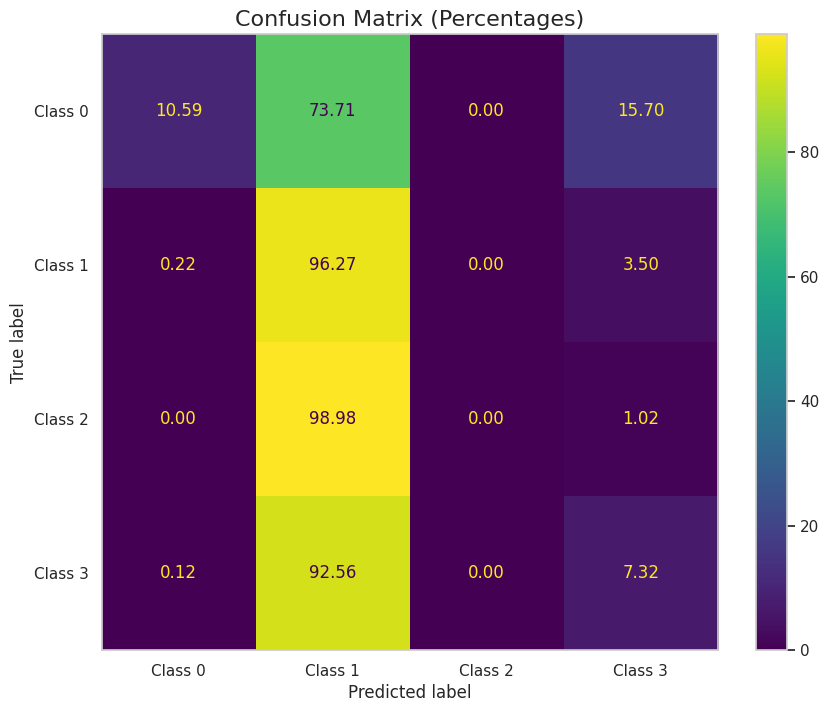

In [75]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test2.flatten(), y_pred_classes_test.flatten())
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, 
                              display_labels=[f'Class {i}' for i in range(conf_matrix.shape[0])])
disp.plot(cmap='viridis', values_format='.2f', ax=plt.gca())  # Display percentages with 2 decimal places
plt.title('Confusion Matrix (Percentages)', fontsize=16)
plt.grid(False)
plt.show()

In [76]:
# Predicted classes
y_pred_classes = np.argmax(y_pred8, axis=-1)  # Shape: (num_sequences, sequence_length)
y_pred_flat = y_pred_classes.flatten()  # Shape: (num_sequences * sequence_length,)

# Indices 
test_data_original= test_data.iloc[:-12]


# Create the sequence indices used for the model
sequence_length = X_test.shape[1]
sequences = []

for i in range(len(test_data_original) - sequence_length + 1):
    sequences.append(test_data_original.iloc[i : i + sequence_length])

# Flatten back to the original row indices
sequence_indices = np.concatenate([range(i, i + sequence_length) for i in range(len(test_data_original) - sequence_length + 1)])

# Combine predictions with the original data
test_data_with_predictions = test_data_original.iloc[sequence_indices].copy()
test_data_with_predictions['predicted_class'] = y_pred_flat[:len(test_data_with_predictions)]


/tmp/ipykernel_23/72726983.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')  # Get the colormap


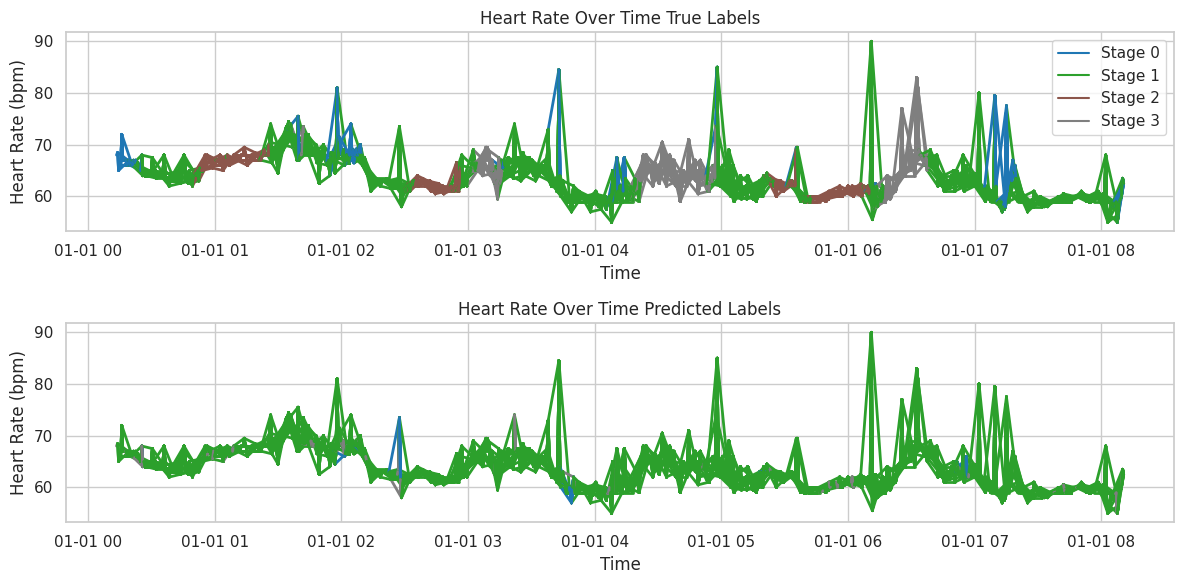

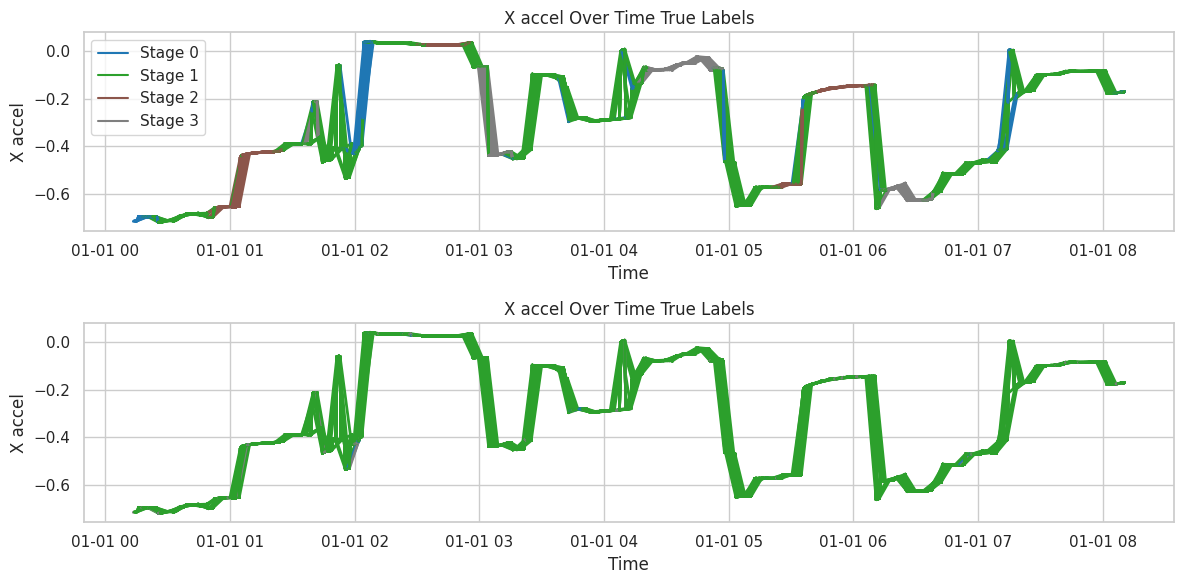

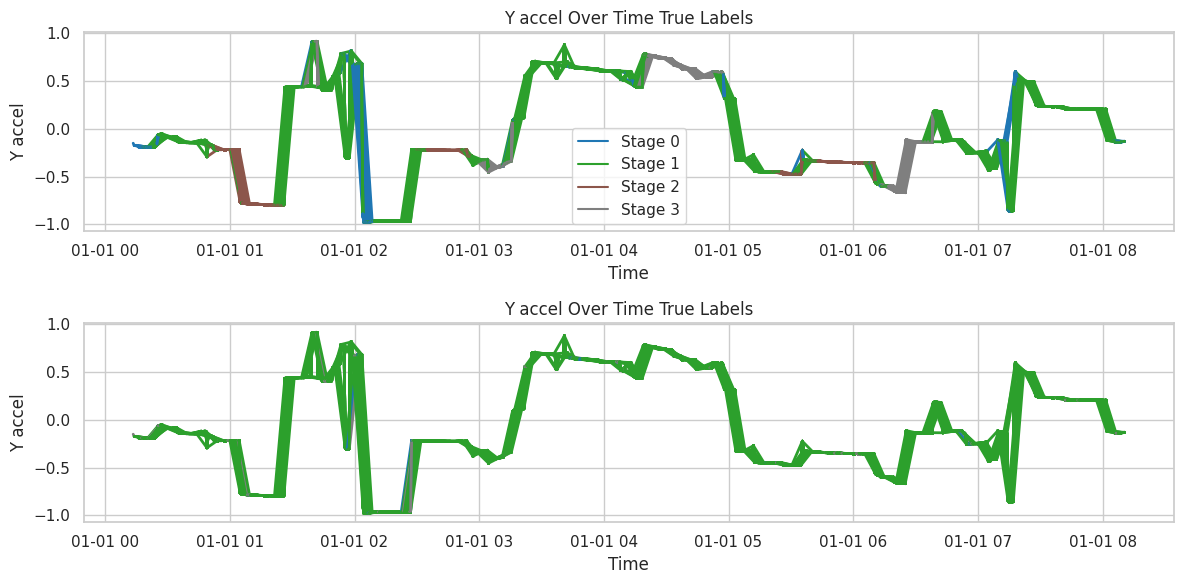

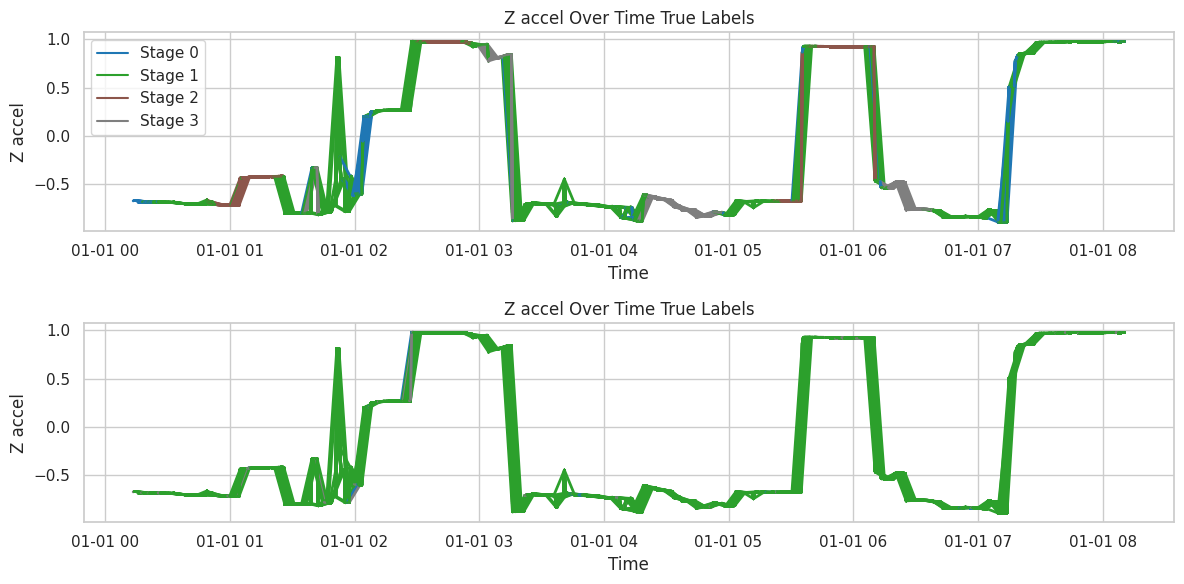

In [78]:
# Create a color map for the sleep stages
sub_data = test_data_with_predictions[test_data_with_predictions['subject_id']=='6220552']

unique_stages = sub_data['sleep_stage'].unique()
cmap = plt.cm.get_cmap('tab10')  # Get the colormap
stage_to_color = {stage: cmap(i / len(unique_stages)) for i, stage in enumerate(sorted(unique_stages))}

# Extract data
heart_rate = sub_data['heart_rate'].values
x_accel = sub_data['x_accel'].values
y_accel = sub_data['y_accel'].values
z_accel = sub_data['z_accel'].values
sleep_stage = sub_data['sleep_stage'].values
predicted_class = sub_data['predicted_class'].values
time = sub_data.index.values  # Time as a NumPy array for iteration

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [heart_rate[i], heart_rate[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Heart Rate Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [heart_rate[i], heart_rate[i + 1]],
        color=stage_to_color[predicted_class[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Heart Rate Over Time Predicted Labels')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
#plt.legend()
plt.grid(True)


#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#------------
# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [x_accel[i], x_accel[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('X accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('X accel')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [x_accel[i], x_accel[i + 1]],
        color=stage_to_color[predicted_class[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('X accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('X accel')
plt.grid(True)


#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#------
# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [y_accel[i], y_accel[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Y accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Y accel')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [y_accel[i], y_accel[i + 1]],
        color=stage_to_color[predicted_class[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Y accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Y accel')
#plt.legend()
plt.grid(True)


#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [z_accel[i], z_accel[i + 1]],
        color=stage_to_color[sleep_stage[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Z accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Z accel')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)

for i in range(len(time) - 1):
    plt.plot(
        [time[i], time[i + 1]],
        [z_accel[i], z_accel[i + 1]],
        color=stage_to_color[predicted_class[i]],
        linewidth=2,
    )

# Add color legend
for stage, color in stage_to_color.items():
    plt.plot([], [], color=color, label=f'Stage {stage}')

plt.title('Z accel Over Time True Labels')
plt.xlabel('Time')
plt.ylabel('Z accel')

plt.grid(True)



plt.grid(True)
plt.tight_layout()
plt.show()

